**📊 National Grid Electricity Demand Forecasting (15-Year Dataset)**

Introduction

In this project, I explored 15 years of UK National Grid electricity demand data to understand historical trends and assess the performance of various forecasting models. The workflow involved data cleaning, exploratory data analysis (EDA), and time series forecasting using both classical and modern machine learning approaches.

The primary aim was to evaluate how well different models could capture the complex seasonal patterns present in electricity demand data. To do this, I tested:

Prophet, a model designed for time series forecasting with strong seasonal components.
    
XGBoost, a powerful gradient boosting framework often used for general-purpose machine learning.
    
LSTM (Long Short-Term Memory), a deep learning model commonly applied to sequence data.

By comparing these approaches, I aimed to highlight their respective strengths, limitations, and suitability for energy demand forecasting tasks.

To communicate the results, I created a 10-minute presentation summarizing the findings and recommendations.

http://docs.google.com/presentation/d/1K2tZQLa5d1jEXbNu7SjzVQpgywQ0sdxQesYwqyDjLPc/edit?usp=sharing



This notebook walks through the full process—from raw data to actionable insights—and includes a discussion of each model’s performance, followed by key conclusions and ideas for further improvements.



In [4]:

import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging

import matplotlib.lines as mlines  # For custom legend handles
import matplotlib.patches as mpatches
import itertools
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot

In [5]:
# load dataframe
df = pd.read_csv("/kaggle/input/national-grid-energy-consumption-2009-2025/National Grid Data 2009-2025.csv", skiprows=3, )
# Change column names to lower case
df.columns = df.columns.str.lower()

Load data¶
I initially used the National Grid API to acess the historic electricity demand between 2009 and 2025. I uploaded the dataset to Kaggle and I will be using it in this notebook.


Exploratory Data Analysis:
In this section, I will go through several steps to understand and transform the original dataset. 

Data Understanding:
The dataset contains many feilds but for the time series analysis we only need the total energy usage at different date and times, in this dataset that is the feilds:

SETTLEMET_DATA: date (dd/mm/yyyy), 
SETTLEMENT_PERIOD: half hourly period of time, 
TSD (Transmission System Demand). 

Transmission System Demand is used rather than National Demand (ND) becasue TSD takes into account additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW. In Short TSD is the Value we wish to predict for future demand managment. 


In [6]:
# Display the first 5 rows to see the data structure
df.head()

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,viking_flow,greenlink_flow
0,01/01/2025,1,21036,26215,19918,5405,6606,0,18720,0,...,-1518,-1026,1,-232,-386,-558.0,96.0,0.0,241.0,0.0
1,01/01/2025,2,21222,26063,20167,5358,6606,0,18720,0,...,-1513,-1023,1,-124,-282,-564.0,51.0,0.0,262.0,0.0
2,01/01/2025,3,21385,25734,20328,5237,6606,0,18720,0,...,-1428,-922,1,-119,-384,-205.0,62.0,0.0,414.0,0.0
3,01/01/2025,4,20473,24988,19460,5115,6606,0,18720,0,...,-1423,-915,0,-119,-334,-193.0,37.0,0.0,423.0,0.0
4,01/01/2025,5,19634,24912,18654,5080,6606,0,18720,0,...,-1539,-899,0,-119,-363,-622.0,-282.0,0.0,288.0,0.0


In [7]:
# Randomly sample 10 rows for a quick look at the data
df.sample(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,viking_flow,greenlink_flow
61346,29-May-21,5,21344,23182,19426,355,6527,0,13080,0,...,809,0,-457,-204,902,0.0,0.0,NaN,NaN,NaN
130231,03-May-17,10,22150,23995,20027,1260,5108,0,12000,0,...,0,802,214,0,0,NaN,NaN,NaN,NaN,NaN
225566,09-Oct-12,17,40990,41922,37136,218,2085,49,1926,0,...,0,307,-247,0,0,NaN,NaN,NaN,NaN,NaN
175673,04-Dec-15,42,37498,38271,34330,3345,4013,0,9063,0,...,0,999,-161,10,0,NaN,NaN,NaN,NaN,NaN
190496,09-Oct-14,35,39868,41031,36050,1204,3679,383,5435,0,...,0,1000,-251,-401,0,NaN,NaN,NaN,NaN,NaN
26148,25/05/2023,39,27902,29115,25573,989,6538,1360,15510,0,...,2000,992,0,-452,-256,359.0,1298.0,997.0,0.0,NaN
61598,03-Jun-21,17,28363,29310,25844,1065,6527,1990,13080,0,...,930,0,-437,0,587,0.0,0.0,NaN,NaN,NaN
17372,23-Nov-24,45,25042,27049,23262,5235,6622,0,18615,0,...,-348,-91,177,384,-209,999.0,1003.0,0.0,679.0,0.0
111145,31-Mar-18,28,32701,33589,29826,2497,5978,1850,13052,0,...,0,705,-207,-176,0,NaN,NaN,NaN,NaN,NaN
13149,27-Aug-24,48,20863,22617,19421,1624,6622,0,18092,0,...,434,39,-689,-237,-314,276.0,1399.0,28.0,307.0,0.0


In [8]:

# Get a summary of the DataFrame, including non-null counts and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282144 entries, 0 to 282143
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   settlement_date            282144 non-null  object 
 1   settlement_period          282144 non-null  int64  
 2   nd                         282144 non-null  int64  
 3   tsd                        282144 non-null  int64  
 4   england_wales_demand       282144 non-null  int64  
 5   embedded_wind_generation   282144 non-null  int64  
 6   embedded_wind_capacity     282144 non-null  int64  
 7   embedded_solar_generation  282144 non-null  int64  
 8   embedded_solar_capacity    282144 non-null  int64  
 9   non_bm_stor                282144 non-null  int64  
 10  pump_storage_pumping       282144 non-null  int64  
 11  scottish_transfer          282144 non-null  int64  
 12  ifa_flow                   282144 non-null  int64  
 13  ifa2_flow                  28

In [9]:

# Show summary statistics for numeric columns (mean, std, quartiles, etc.)
df.describe()


,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,...,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,viking_flow,greenlink_flow
count,282144.000000,282144.000000,282144.000000,282144.000000,282144.000000,282144.000000,282144.000000,282144.000000,282144.000000,282144.000000,...,282144.000000,282144.000000,282144.000000,282144.000000,282144.000000,106848.000000,106848.000000,36720.000000,36720.000000,19200.000000
mean,24.500227,31189.813684,32637.018483,28395.189938,1282.261345,4469.763468,876.979319,8821.689705,6.586311,304.010144,...,121.605311,523.124334,-62.562978,-53.864520,92.549673,218.283665,301.703953,491.621705,228.603023,-0.380781
std,13.853817,7815.316918,7695.665228,7076.257491,981.263910,1959.289408,1712.095605,5981.777179,38.956189,527.010186,...,519.005689,511.282604,336.815452,262.862902,392.317339,510.197168,686.688423,528.439998,584.206536,56.716712
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,...,-2071.000000,-1215.000000,-1089.000000,-585.000000,-1022.000000,-1455.000000,-1454.000000,-1027.000000,-1465.000000,-537.000000
25%,12.750000,24921.000000,26600.000000,22690.000000,553.000000,2109.000000,0.000000,2056.000000,0.000000,8.000000,...,0.000000,0.000000,-251.000000,-249.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.500000,30505.000000,31796.000000,27770.000000,1021.000000,4856.000000,0.000000,11503.000000,0.000000,11.000000,...,0.000000,736.000000,-95.000000,0.000000,0.000000,0.000000,0.000000,666.500000,0.000000,0.000000
75%,36.250000,36918.000000,38107.000000,33622.250000,1742.000000,6527.000000,877.000000,13080.000000,0.000000,368.000000,...,0.000000,992.000000,85.000000,0.000000,0.000000,693.000000,1079.000000,996.000000,691.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5962.000000,6622.000000,11498.000000,18720.000000,893.000000,2019.000000,...,2041.000000,1143.000000,1078.000000,504.000000,1033.000000,1401.000000,1400.000000,1001.000000,1436.000000,505.000000


In [10]:
# Check the shape of the DataFrame (rows, columns)
df.shape

(282144, 22)

Data Preparation: 
Now we understand what the data looks like we can start cleaning it by removing the columns with NaN values as well as any settlement periods aboce 48 as there can only be that many in a day (24/2). 


In [11]:
print(df.iloc[:, :23].isna().any())
# search dataframe for nul values, if present = true 

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
scottish_transfer            False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                     True
nsl_flow                      True
eleclink_flow                 True
viking_flow                   True
greenlink_flow                True
dtype: bool


we can see that 5 columns contain null values, to work out how big of an issue it is we can count all the null values for each row. 

In [12]:
print(df.columns)

Index(['settlement_date', 'settlement_period', 'nd', 'tsd',
       'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow',
       'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow',
       'eleclink_flow', 'viking_flow', 'greenlink_flow'],
      dtype='object')


In [13]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["nemo_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
        df["viking_flow"].isna().value_counts().to_frame(),
        df["greenlink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True 
).rename(columns={0: "nsl_flow", 1: "nemo_flow", 2: "eleclink_flow", 3: "viking_flow", 4: "greenlink_flow"})


,nsl_flow,nemo_flow,eleclink_flow,viking_flow,greenlink_flow
True,175296,175296,245424,245424,262944
False,106848,106848,36720,36720,19200


In [14]:
# Convert settlement_period (1-48) into time format (HH:MM)
df["settlement_time"] = df["settlement_period"].apply(lambda x: f"{(x-1)//2:02}:{(x%2)*30:02}")

# Display the first few rows to verify the changes
print(df[["settlement_period", "settlement_time"]].head(10))



   settlement_period settlement_time
0                  1           00:30
1                  2           00:00
2                  3           01:30
3                  4           01:00
4                  5           02:30
5                  6           02:00
6                  7           03:30
7                  8           03:00
8                  9           04:30
9                 10           04:00


there are alot of null values in these columns, lets take a closer look

In [15]:
df.loc[(df["eleclink_flow"].isna())  | (df["nsl_flow"].isna()) | (df["nsl_flow"].isna()) | (df["nemo_flow"].isna()) | (df["viking_flow"].isna()) | (df["greenlink_flow"].isna()), :]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,viking_flow,greenlink_flow,settlement_time
19200,01/01/2023,1,21043,24680,18995,2815,6545,0,15005,0,...,903,-896,-451,-529,253.0,235.0,998.0,0.0,NaN,00:30
19201,01/01/2023,2,21756,25289,19730,2793,6545,0,15005,0,...,904,-897,-451,-529,252.0,157.0,998.0,0.0,NaN,00:00
19202,01/01/2023,3,21348,25269,19327,2773,6545,0,15005,0,...,983,-910,-451,-529,253.0,-219.0,999.0,0.0,NaN,01:30
19203,01/01/2023,4,20586,24574,18589,2753,6545,0,15005,0,...,989,-911,-413,-529,254.0,-298.0,999.0,0.0,NaN,01:00
19204,01/01/2023,5,19781,24135,17806,2712,6545,0,15005,0,...,903,-912,-401,-529,253.0,-679.0,998.0,0.0,NaN,02:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282139,31-Dec-09,44,36645,37556,32468,1019,1773,0,0,0,...,0,-304,0,0,NaN,NaN,NaN,NaN,NaN,21:00
282140,31-Dec-09,45,35572,36392,31489,1019,1773,0,0,0,...,0,-213,0,0,NaN,NaN,NaN,NaN,NaN,22:30
282141,31-Dec-09,46,35398,36181,31260,951,1773,0,0,0,...,0,-170,0,0,NaN,NaN,NaN,NaN,NaN,22:00
282142,31-Dec-09,47,35005,36062,30855,951,1773,0,0,0,...,0,-169,0,0,NaN,NaN,NaN,NaN,NaN,23:30


are there are large sections that are completly null we should just get rid of these columns as they wont be needed for the analysis anyway. 

In [16]:
print(df.columns)  # Check column names


Index(['settlement_date', 'settlement_period', 'nd', 'tsd',
       'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow',
       'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow',
       'eleclink_flow', 'viking_flow', 'greenlink_flow', 'settlement_time'],
      dtype='object')


<ipython-input-17-517cfac5d72c>:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_plot.index = pd.to_datetime(df_plot.index, format="mixed", dayfirst=True, infer_datetime_format=True)


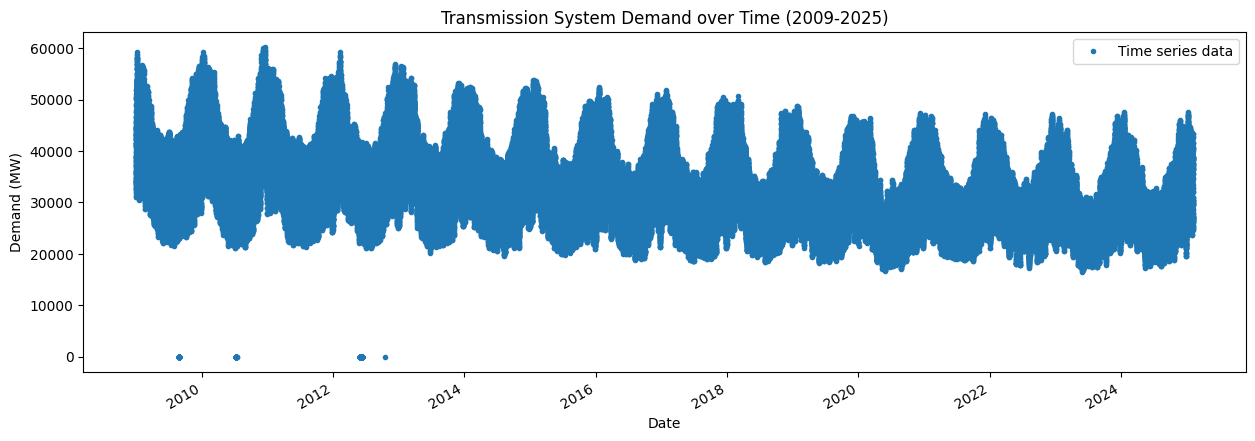

In [17]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index, format="mixed", dayfirst=True, infer_datetime_format=True)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", 
    ax=ax, 
    title="Transmission System Demand over Time (2009-2025)", 
    label="Time series data", 
)
ax.set_ylabel("Demand (MW)"),
ax.set_xlabel("Date")
ax.legend()

this plot is great becasue it clearly shows consistent anual trends and a slight decreasing trajectory over time which is interesting aa i would assume total energy need would be going up over time due to population growth.  and it also reveals some outliers we have lurking at y = 0. 

Now we can remove the outliers at 0 and create new plots to be able to see any daily or weekly patterns. 



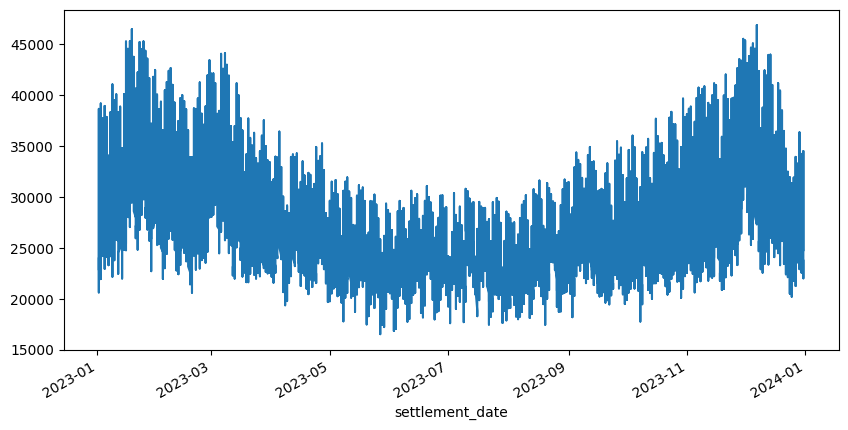

In [18]:
df_plot.loc[(df_plot.index > "01-01-2023") & (df_plot.index < "01-01-2024")][
    "tsd"
].plot(figsize=(10, 5));

This Plot over 8 months shows more energy is used in winter months which is expected as colder months require more energy to heat houses so anyone with an electric boiler will be using more electricity. it would be interesting to see if disparity between summer and winter use will grow larger as electric boilers are pushed as a greener alternative to gas boilers which are still over 80% of households in the UK. 

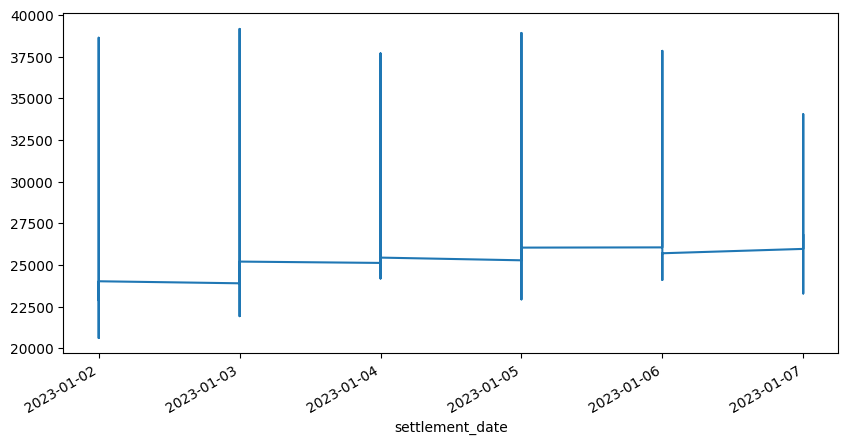

In [19]:
df_plot.loc[(df_plot.index > "01-01-2023") & (df_plot.index < "01-08-2023")][
    "tsd"
].plot(figsize=(10, 5));

Zooming in even further we get this plot showing a weeks usage. the graph dosnt look right, the large spikes at 12;00 are because so far we have only used date values, ommiting the hours casues all 48 values per day to default to the first position. To correct this we need to convert the 1-48 value into 00:00-23:30 time values. then concatinate the date and time into a single datetime feild which we can make the index for future plots. 

In [20]:
df.iloc[:, :4].head()

,settlement_date,settlement_period,nd,tsd
0,01/01/2025,1,21036,26215
1,01/01/2025,2,21222,26063
2,01/01/2025,3,21385,25734
3,01/01/2025,4,20473,24988
4,01/01/2025,5,19634,24912


the plot does not look any different at this level but if we zoom back in to the week scale we can see that it worked. 

GRAPH NOT WORKING 
This is more like what i would expect the daily plots to look like, and we can see the energy usage dips to its lowes level in the middle of the night to early morning, and peaks in the afternoon when people are home from work. It looks like block of 5 consecutive days have more use, or atleast a higher peak, my first thought seeing this is that it represents the weekdays, with the weekends having lower usage posibly because people are out or just spread out more as people have all day to do activities requring electricity like laundry, cooking etc, spreading out the distrubution. To see if this is indeed a pattern we can zoom out slighly 

In [21]:
df = df.reset_index()

# Ensure 'settlement_date' is in datetime format with mixed format handling
df["settlement_date"] = pd.to_datetime(df["settlement_date"], format="mixed", dayfirst=True)

# Set the correct index for resampling
df = df.set_index("settlement_date")

# Resample to daily and sum 'tsd' values per day
df_daily_totals = df["tsd"].resample("D").sum()

# Filter the date range correctly
df_filtered = df_daily_totals.loc["2023-01-01":"2023-01-08"]

# Display results
print(df_filtered)

settlement_date
2023-01-01    1275187
2023-01-02    1343616
2023-01-03    1488775
2023-01-04    1449398
2023-01-05    1490792
2023-01-06    1471403
2023-01-07    1341043
2023-01-08    1419619
Freq: D, Name: tsd, dtype: int64


By checking the total TSD for each day we can see that, yes the weekends (1st, 2nd, 7th) do has less power usage than the weekdays, not mearly more spread out throughout the day. 

Now we need to remove the outliers at zero we found earlier. As we dont know why these TSD values are 0 we dont know how the surrounding intervals are affected so we should remove the full days where a zero TSD is present. 




In [22]:
df = df.reset_index()  # Moves current index (e.g., 'datetime') back to a column

# Step 1: Identify unique days where 'tsd' (Transmission System Demand) is exactly 0.0
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

# Step 2: Initialize an empty list to store the indices of all rows from these days
null_days_index = []

# Step 3: Loop through each day in 'null_days' and find all row indices for that day
for day in null_days:
    # Get all indices where 'settlement_date' matches the current 'day' and store them
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

# Step 4: Flatten the list of lists into a single list of row indices
null_days_index = [item for sublist in null_days_index for item in sublist]

# Step 5: Drop all rows corresponding to these indices from the DataFrame
df.drop(index=null_days_index, inplace=True)

# Step 6: Reset the index after removing rows to maintain sequential numbering
df.reset_index(drop=True, inplace=True)

# Check if any rows with tsd == 0.0 still exist
zero_tsd_rows = df[df["tsd"] == 0.0]

# Print the first few rows if any exist
if zero_tsd_rows.empty:
    print("✅ All rows with tsd = 0.0 have been successfully deleted.")
else:
    print("⚠️ Some rows with tsd = 0.0 still exist:")
    print(zero_tsd_rows.head())  # Display first few remaining rows (if any)



✅ All rows with tsd = 0.0 have been successfully deleted.


Feature Understanding: 

Now that we have cleaned the data and established that there are trends present, we can create more useful charts to display these trends. 

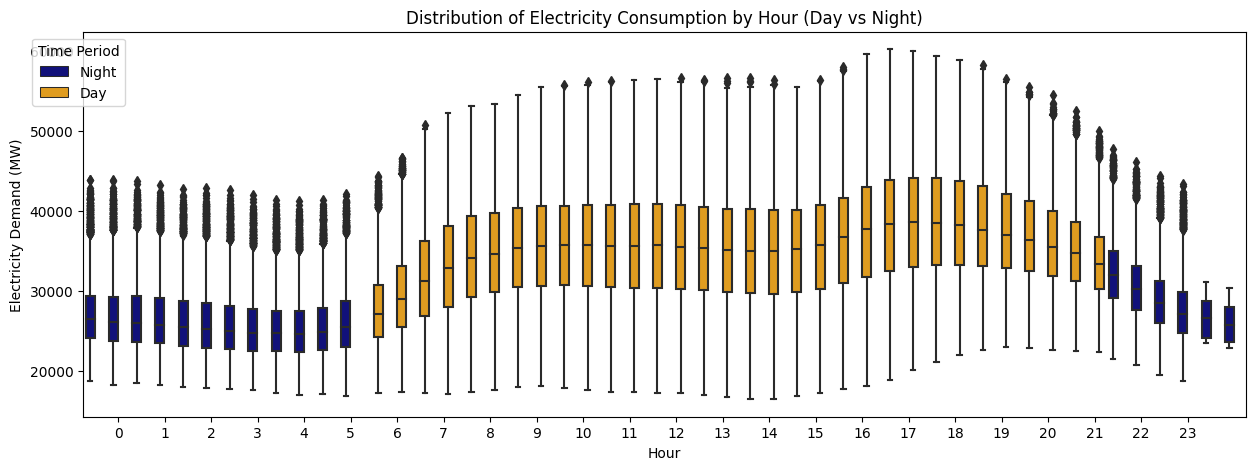

In [48]:

# Define a function to classify settlement periods as 'Day' or 'Night'
def get_time_period(settlement_period):
    # Convert settlement period (1-48) into 24-hour format
    hour = (settlement_period - 1) // 2  # Each period represents 30 min
    if hour < 6 or hour >= 22:  # Night: 00:00-06:00 & 22:00-23:30
        return "Night"
    else:
        return "Day"

# Apply function to create 'time_period' column
df["time_period"] = df["settlement_period"].apply(get_time_period)

# Define custom colors for night and day
time_colors = {"Night": "darkblue", "Day": "orange"}

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(
    x="settlement_period", y="tsd", data=df, 
    hue="time_period", palette=time_colors
)

# Adjust x-axis ticks to show hours properly
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(0, 24))  # Convert settlement periods to 24-hour format

ax.set_xlabel("Hour")
ax.set_ylabel("Electricity Demand (MW)")
ax.set_title("Distribution of Electricity Consumption by Hour (Day vs Night)")

plt.legend(title="Time Period", loc="upper left", bbox_to_anchor=(-0.05, 1))
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

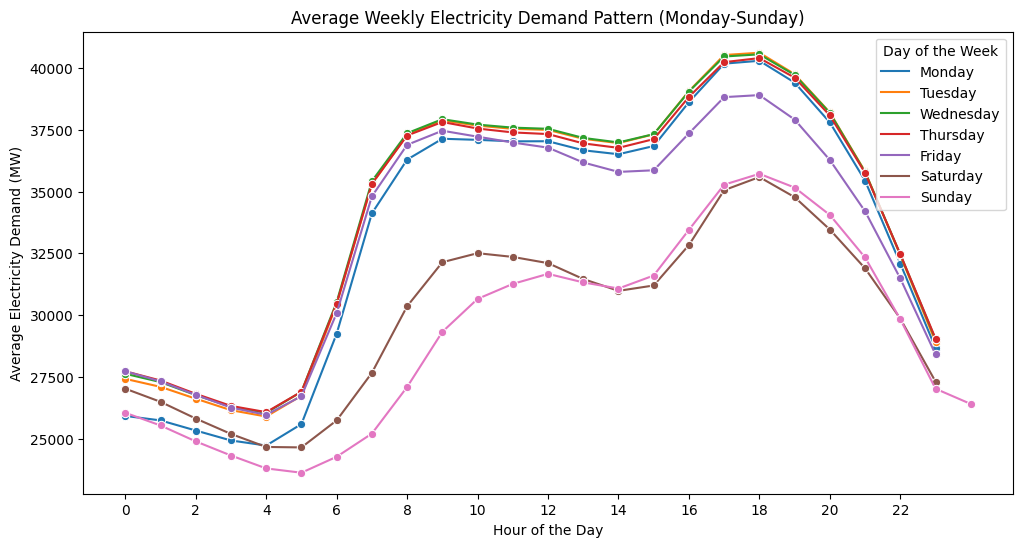

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'settlement_date' is in datetime format
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True)

# Extract day of the week (Monday=0, Sunday=6) and hour of the day
df["day_of_week"] = df["settlement_date"].dt.dayofweek
df["hour"] = (df["settlement_period"] - 1) // 2  # Convert settlement period to 24-hour format

# Group data by (day_of_week, hour) and compute the average electricity demand
df_weekly_avg = df.groupby(["day_of_week", "hour"])["tsd"].mean().reset_index()

# Map numerical day values to actual weekday names
day_labels = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
              4: "Friday", 5: "Saturday", 6: "Sunday"}
df_weekly_avg["day_name"] = df_weekly_avg["day_of_week"].map(day_labels)

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_weekly_avg, x="hour", y="tsd", hue="day_name", marker="o", palette="tab10"
)

# Labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Average Electricity Demand (MW)")
plt.title("Average Weekly Electricity Demand Pattern (Monday-Sunday)")
plt.xticks(range(0, 24, 2))  # Show even hours only for better readability
plt.legend(title="Day of the Week", loc="upper right")

# Show the plot
plt.show()


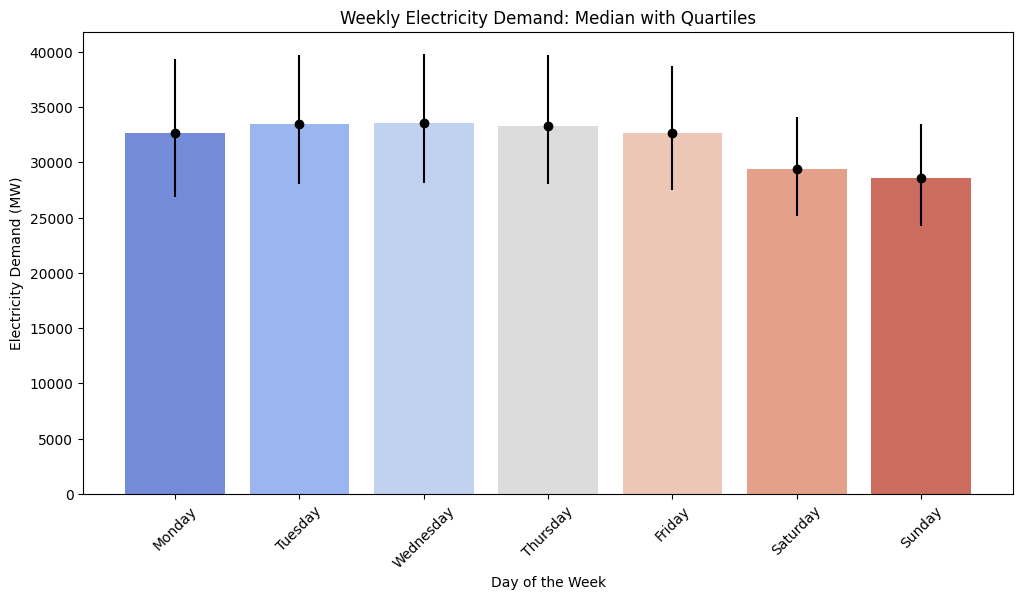

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'settlement_date' is in datetime format
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True)

# Extract day of the week (Monday=0, Sunday=6)
df["day_of_week"] = df["settlement_date"].dt.dayofweek

# Map numerical day values to actual weekday names
day_labels = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
              4: "Friday", 5: "Saturday", 6: "Sunday"}
df["day_name"] = df["day_of_week"].map(day_labels)

# Group data by day of the week and calculate summary statistics
df_weekly_summary = df.groupby("day_name").agg(
    median=("tsd", "median"),
    mean=("tsd", "mean"),
    std=("tsd", "std"),
    min=("tsd", "min"),
    max=("tsd", "max"),
    q25=("tsd", lambda x: x.quantile(0.25)),  # 25th percentile
    q75=("tsd", lambda x: x.quantile(0.75))   # 75th percentile
).reset_index()

# Sort days of the week correctly
df_weekly_summary["day_of_week"] = df_weekly_summary["day_name"].map({v: k for k, v in day_labels.items()})
df_weekly_summary = df_weekly_summary.sort_values("day_of_week")

# Create the bar chart with quartiles
plt.figure(figsize=(12, 6))
sns.barplot(
    x="day_name", y="median", data=df_weekly_summary,
    capsize=0.2, palette="coolwarm"
)

# Add error bars for interquartile range (IQR: 25%-75%)
for i, row in enumerate(df_weekly_summary.itertuples()):
    plt.errorbar(i, row.median, yerr=[[row.median - row.q25], [row.q75 - row.median]], fmt="o", color="black")

# Labels and title
plt.xlabel("Day of the Week")
plt.ylabel("Electricity Demand (MW)")
plt.title("Weekly Electricity Demand: Median with Quartiles")
plt.xticks(rotation=45)

# Show the plot
plt.show()



here we can see a much clearer idea of how electrcitiy use varies throughut the day, averaged over all days. 2009 to present. we can see the more electricity is used in all daytime hours, trhan at night.

<ipython-input-26-bd9c73aa79ab>:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)


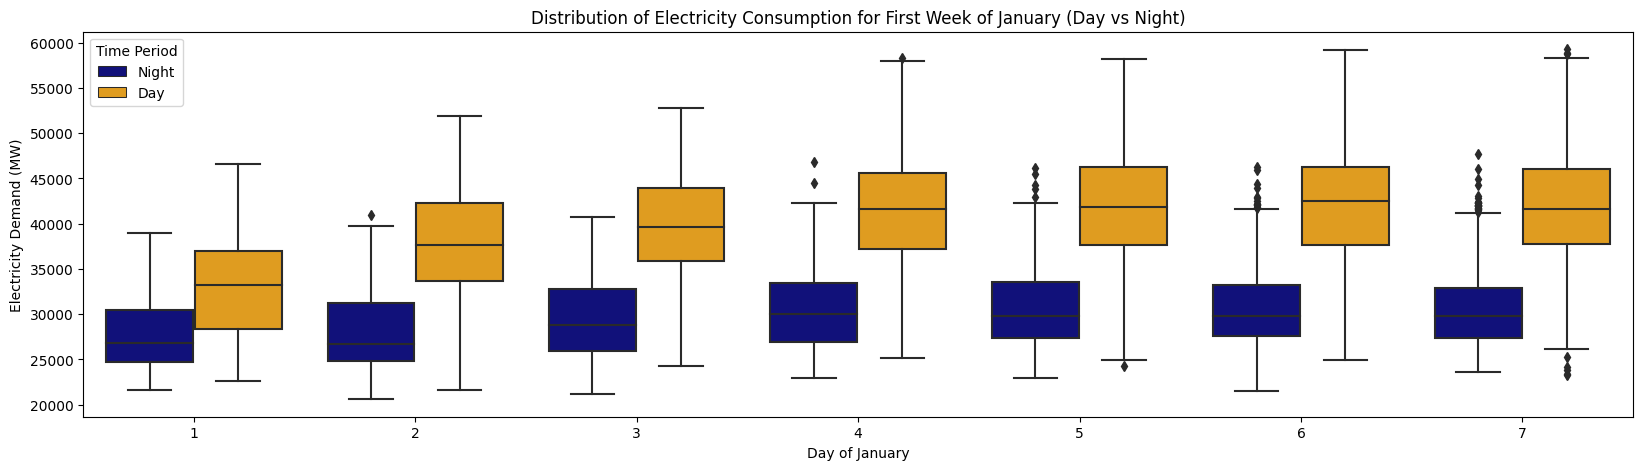

In [26]:
# Define function to classify settlement periods as 'Day' or 'Night'
def get_time_period(settlement_period):
    hour = (settlement_period - 1) // 2  # Convert settlement period (1-48) to 24-hour format
    return "Night" if hour < 6 or hour >= 22 else "Day"

# Ensure 'settlement_date' is in datetime format
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)

# Extract data for the first week of January across all years
df_january = df[(df["settlement_date"].dt.month == 1) & (df["settlement_date"].dt.day <= 7)].copy()

# Apply function to create 'time_period' column
df_january["time_period"] = df_january["settlement_period"].apply(get_time_period)

# Define custom colors for night and day
time_colors = {"Night": "darkblue", "Day": "orange"}

# Create the plot
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(
    x=df_january["settlement_date"].dt.day,  # Group by day of the month (1st - 7th)
    y="tsd",
    data=df_january,
    hue="time_period",
    palette=time_colors
)

ax.set_xlabel("Day of January")
ax.set_ylabel("Electricity Demand (MW)")
ax.set_title("Distribution of Electricity Consumption for First Week of January (Day vs Night)")

plt.legend(title="Time Period")  # Add legend for Day/Night
plt.show()

Alternative chart showing energy use differnece in day and night hours. 

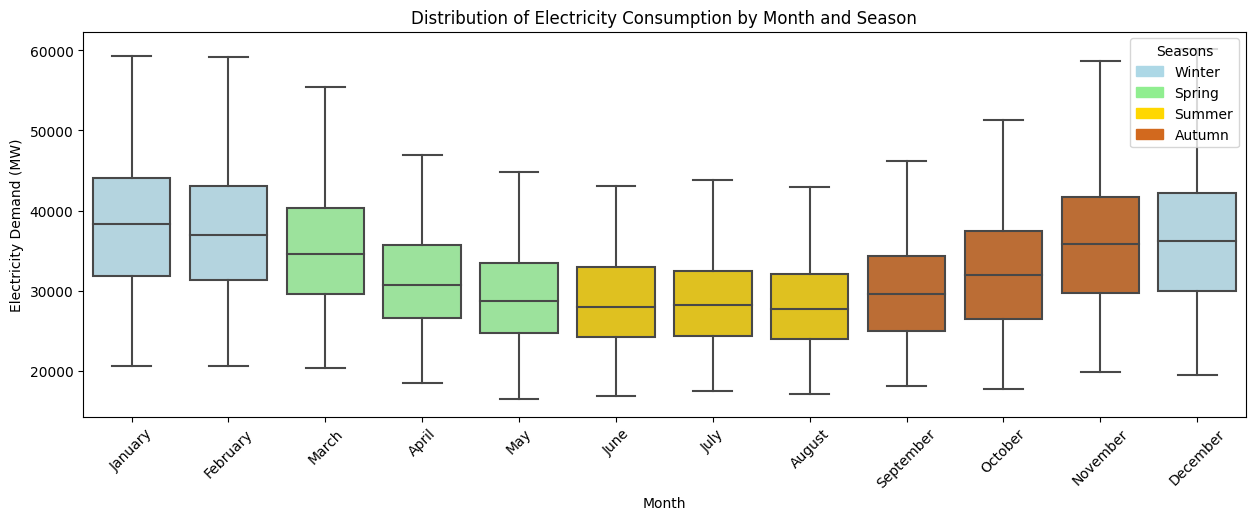

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches  # For custom legend

# Ensure 'settlement_date' is in datetime format
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True)

# Extract month number and month name
df["month"] = df["settlement_date"].dt.month
df["month_name"] = df["settlement_date"].dt.strftime("%B")

# Define season colors
season_colors = {
    "Winter": "lightblue",
    "Spring": "lightgreen",
    "Summer": "gold",
    "Autumn": "chocolate"
}

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df["season"] = df["month"].apply(get_season)

# Map colors to months based on their season
month_colors = [season_colors[get_season(m)] for m in range(1, 13)]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month_name", y="tsd", data=df, 
            order=["January", "February", "March", "April", "May", "June",
                   "July", "August", "September", "October", "November", "December"],
            palette=month_colors)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity Demand (MW)")
ax.set_title("Distribution of Electricity Consumption by Month and Season")

plt.xticks(rotation=45)  # Rotate labels for better readability

# Create a custom legend for seasons
legend_patches = [mpatches.Patch(color=color, label=season) for season, color in season_colors.items()]
plt.legend(handles=legend_patches, title="Seasons", loc="upper right")

plt.show()


Here we can see that electricity use in the UK has a strong seasonal trend where least is used in summer as no heating is required and Air conditioning is not common in domestic market in the UK. wheras in winter months the electricity usage peaks. with autumn and spring being where the transition happens from high to low usage. 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure datetime is properly formatted
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True)


# Extract year and time of day
df["year"] = df["settlement_date"].dt.year
df["hour"] = df["settlement_period"] / 2  # Convert settlement periods (1-48) to 0-24 hour format

# Get sorted unique years and remove 2025
unique_years = sorted(df["year"].unique())
unique_years = [year for year in unique_years if year != 2025]  # Exclude 2025

# Select every other year
filtered_years = unique_years[::2]  # Take every other year

# Filter dataset
df_filtered = df[df["year"].isin(filtered_years)]

# Define different marker styles for each year
marker_styles = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', 'h', '+', 'x']
year_markers = {year: marker_styles[i % len(marker_styles)] for i, year in enumerate(filtered_years)}

# Create plot
plt.figure(figsize=(15, 6))

for year in filtered_years:
    df_year = df_filtered[df_filtered["year"] == year]
    sns.lineplot(data=df_year, x="hour", y="tsd", label=year, 
                 marker=year_markers[year], markersize=8, alpha=0.8)

# Labels and title
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Electricity Demand (MW)")
plt.title("Electricity Demand Trends (Every Other Year, Excluding 2025)")

# X-axis formatting
plt.xticks(range(0, 25, 2))  # Show full-hour labels

# Legend positioning
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

I made this chart to represent the trend in energy usage over the years, we can see that the daily trends stays the same but the overall usage is falling year on year. This is a suprising result to me, i asumed with constantly rising population we would be using more energy. From researching online it does appear to be the case and the reason is put down to several factors; constantly improving energy efficency of devices and homes, reduction of manufacturing in UK, high prices discouraging people and companys from using it. 

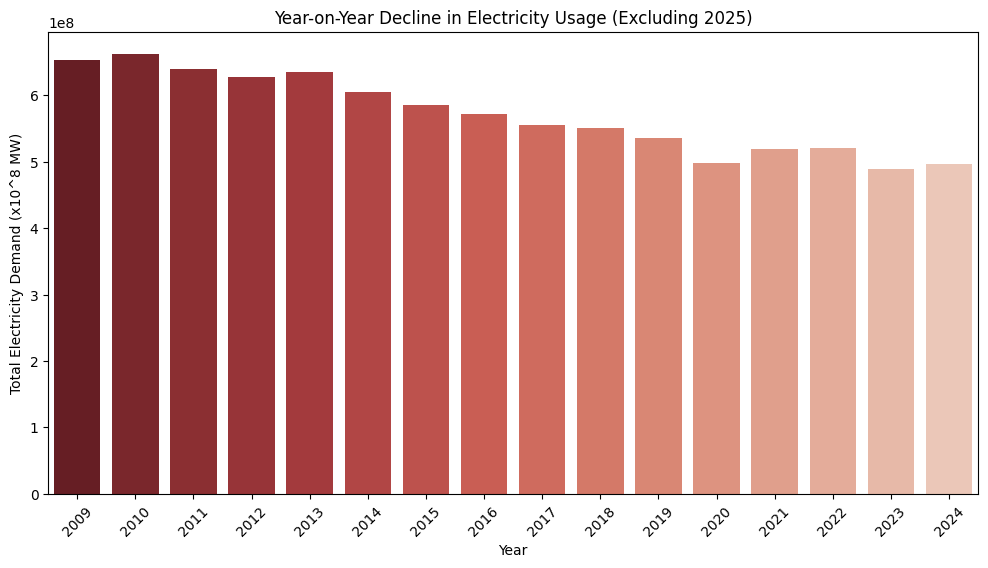

In [29]:
# Re-import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'settlement_date' is in datetime format
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True)

# Extract year and filter out 2025
df["year"] = df["settlement_date"].dt.year
df_filtered = df[df["year"] < 2025]  # Exclude 2025

# Aggregate yearly electricity demand
df_yearly_totals = df_filtered.groupby("year")["tsd"].sum().reset_index()

# Create a bar chart to represent year-on-year decline in electricity usage
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="year", y="tsd", data=df_yearly_totals, palette = sns.color_palette("Reds", n_colors=20, desat=0.8)[::-1])

# Formatting the plot
ax.set_xlabel("Year")
ax.set_ylabel("Total Electricity Demand (x10^8 MW)")
ax.set_title("Year-on-Year Decline in Electricity Usage (Excluding 2025)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

this plot more clearly shows the continued yearly decline but does not show that the daily trends remain constant.

**TIME SERIES MODELING**

Now we have a good uneerstanding of the dataset we can apply some models to find one with good predicitve capabilities in order to be abel to predict trends in the load over time, inlcuding significant peaks and troughs which would requre adjsutmetns to the grid as well as long term trends which will effect instrastrucure development. 

The first model i will use is prophet,developed by Facebook, Prophet is designed to handle complex seasonality (daily, weekly, yearly) and holiday effects. It’s robust to missing data and outliers.

In [ ]:
%matplotlib inline
# Ensure 'settlement_date' is in datetime format
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)

# Aggregate data to daily totals (summing the 'tsd' column)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()

# Prophet requires the dataframe to have columns named 'ds' for date and 'y' for the target variable
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)

# Initialize the Prophet model and fit it to the daily aggregated data
model = Prophet()
model.fit(df_daily)

# Create a dataframe to hold predictions for the next 3 years
future = model.make_future_dataframe(periods=1095)

# Predict future values
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
ax = fig.gca()

# Create custom legend handles:
# Historical Data: Black dots (actual observations)
historical_handle = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=8, label='Historical Data')
# Forecast Trend: Blue line
forecast_handle = mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='Forecast Trend')
# Uncertainty Interval: Light blue patch (approximate)
uncertainty_handle = mpatches.Patch(color='lightblue', label='Uncertainty Interval')

# Add the legend to the plot
ax.legend(handles=[historical_handle, forecast_handle, uncertainty_handle], loc='upper left')

# Additional formatting
plt.title("Prophet Forecast on Daily Aggregated Data")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.show()

<ipython-input-30-fd1ede0fcb4c>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
10:47:50 - cmdstanpy - INFO - Chain [1] start processing
10:47:52 - cmdstanpy - INFO - Chain [1] done processing


The prophet model is doing a good job capturing the trend of previous years and forcasting it 3 years into the future.

In [ ]:

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_daily)

# Create a future dataframe covering the desired period.
# Here, we forecast 3 years into the future (approx. 365*3 days) so we cover 2024 to 2026.
future = model.make_future_dataframe(periods=365 * 3)
forecast = model.predict(future)

# Plot the forecast using Prophet's built-in plotting function
fig = model.plot(forecast)
ax = fig.gca()

# Create custom legend handles:
# Historical Data: Black dots (actual observations)
historical_handle = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=8, label='Historical Data')
# Forecast Trend: Blue line
forecast_handle = mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='Forecast Trend')
# Uncertainty Interval: Light blue patch (approximate)
uncertainty_handle = mpatches.Patch(color='lightblue', label='Uncertainty Interval')

# Add the legend to the plot
ax.legend(handles=[historical_handle, forecast_handle, uncertainty_handle], loc='upper left')

# Zoom in to the 2024-2026 period by setting x-axis limits
ax.set_xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2026-03-31"))
plt.title("Prophet Forecast (Zoomed In: 2024-2026)")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.show()

10:47:54 - cmdstanpy - INFO - Chain [1] start processing
10:47:56 - cmdstanpy - INFO - Chain [1] done processing


zooming in we can see that the daily and monthly patterns are captured too, not smoothed out by overcorrection.

<ipython-input-32-7bd706a9569c>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)


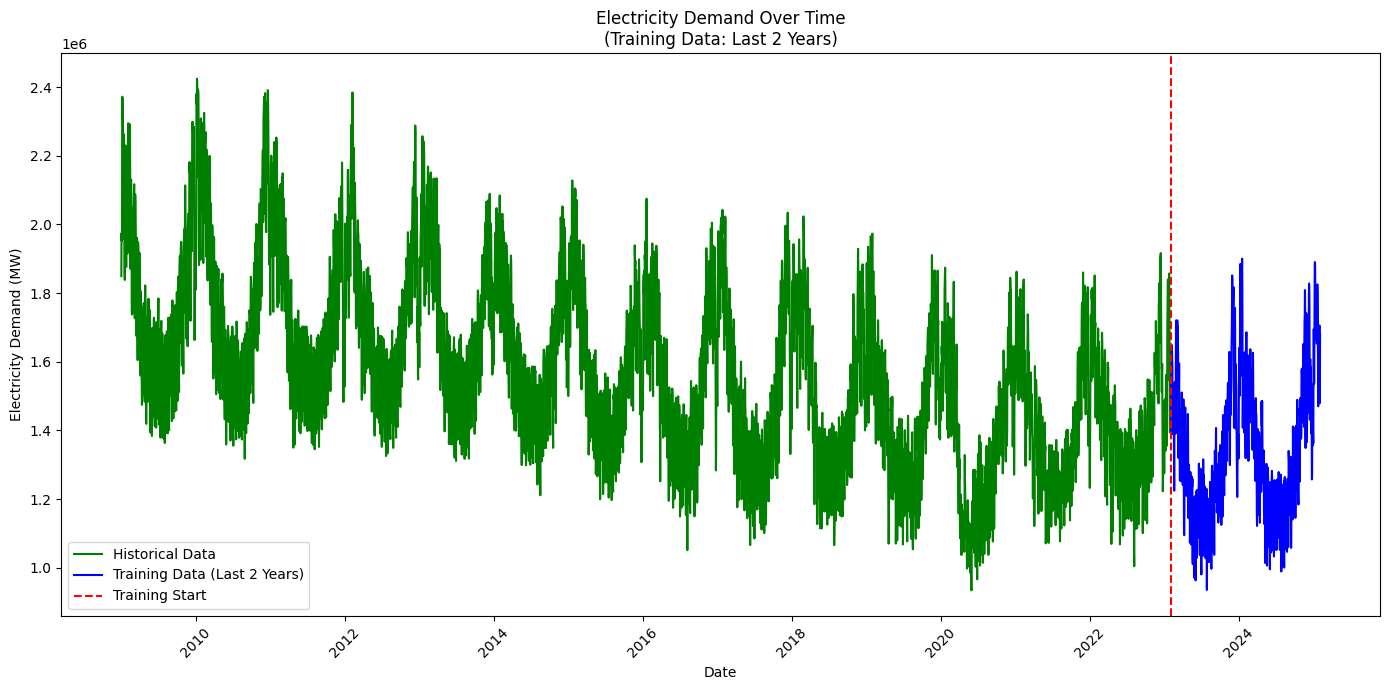

In [32]:
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)

# Aggregate data to daily totals by summing 'tsd'
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()

# --- Step 2: Determine the Training Period ---
# Identify the maximum date in the dataset
max_date = df_daily["settlement_date"].max()

# Define the training period as the last 2 years
training_start = max_date - pd.DateOffset(years=2)

# Create a new column to mark each row as "Historical" or "Training"
df_daily["data_type"] = df_daily["settlement_date"].apply(lambda x: "Training" if x >= training_start else "Historical")

# --- Step 3: Plot the Entire Dataset with Training Data Highlighted ---
plt.figure(figsize=(14, 7))

# Plot historical data (before training period) in gray
historical = df_daily[df_daily["data_type"] == "Historical"]
plt.plot(historical["settlement_date"], historical["tsd"], label="Historical Data", color="green")

# Plot training data (last 2 years) in blue
training = df_daily[df_daily["data_type"] == "Training"]
plt.plot(training["settlement_date"], training["tsd"], label="Training Data (Last 2 Years)", color="blue")

# Draw a vertical line to mark the start of the training period
plt.axvline(training_start, color="red", linestyle="--", label="Training Start")

# Format the plot
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("Electricity Demand Over Time\n(Training Data: Last 2 Years)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-51-cc4897f6c10f>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
11:37:30 - cmdstanpy - INFO - Chain [1] start processing
11:37:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE	3.83%


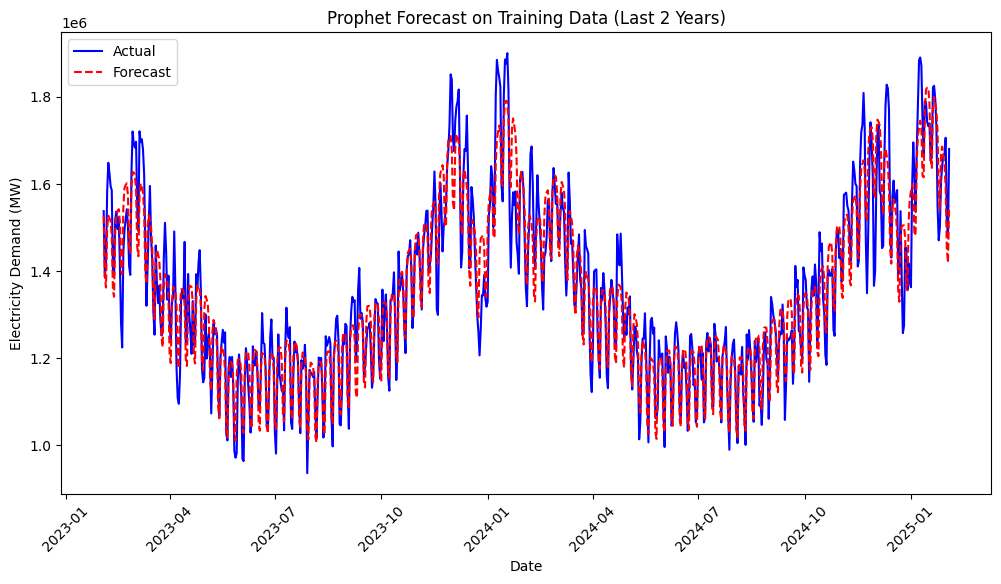

In [51]:

# --- Step 1: Preprocess and Aggregate Data ---
# Ensure 'settlement_date' is in datetime format
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
# Aggregate data to daily totals by summing 'tsd'
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
# Prophet requires the columns to be named 'ds' (date) and 'y' (target variable)
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)

# --- Step 2: Define Training Period (Last 2 Years) ---
max_date = df_daily["ds"].max()
training_start = max_date - pd.DateOffset(years=2)
train_data = df_daily[df_daily["ds"] >= training_start].copy()

# --- Step 3: Fit Prophet Model on Training Data ---
model = Prophet()
model.fit(train_data)

# --- Step 4: Forecast on the Training Period ---
# Use the dates from the training data for forecasting
future = train_data[["ds"]].copy()
forecast = model.predict(future)

# --- Step 5: Compute Mean Absolute Percentage Error (MAPE) ---
# MAPE = mean(|actual - forecast| / actual) * 100
actual = train_data["y"].values
predicted = forecast["yhat"].values
# Avoid division by zero using np.where; if actual==0, set denominator to NaN
mape = np.mean(np.abs((actual - predicted) / np.where(actual==0, np.nan, actual))) * 100
print("MAPE\t" + f"{mape:.2f}%")

# --- Step 6: Plot Actual vs. Forecast and Add MAPE Table ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_data["ds"], train_data["y"], label="Actual", color="blue")
ax.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="red", linestyle="--")
ax.set_xlabel("Date")
ax.set_ylabel("Electricity Demand (MW)")
ax.set_title("Prophet Forecast on Training Data (Last 2 Years)")
ax.legend()
plt.xticks(rotation=45)
plt.show()


10:47:58 - cmdstanpy - INFO - Chain [1] start processing
10:48:00 - cmdstanpy - INFO - Chain [1] done processing


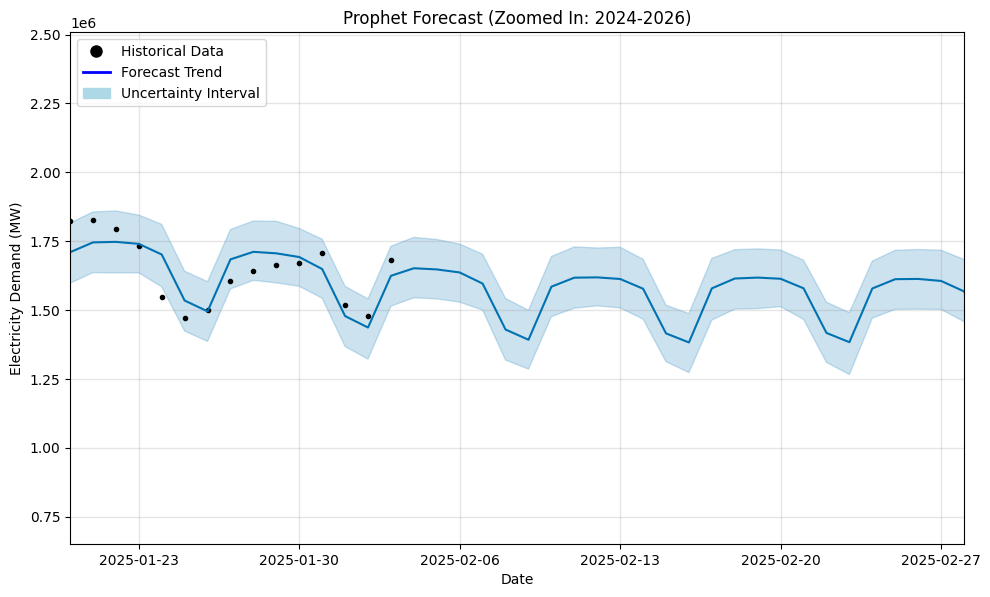

In [34]:

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_daily)

# Create a future dataframe covering the desired period.
# Here, we forecast 3 years into the future (approx. 365*3 days) so we cover 2024 to 2026.
future = model.make_future_dataframe(periods=365 * 3)
forecast = model.predict(future)

# Plot the forecast using Prophet's built-in plotting function
fig = model.plot(forecast)
ax = fig.gca()

# Create custom legend handles:
# Historical Data: Black dots (actual observations)
historical_handle = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=8, label='Historical Data')
# Forecast Trend: Blue line
forecast_handle = mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='Forecast Trend')
# Uncertainty Interval: Light blue patch (approximate)
uncertainty_handle = mpatches.Patch(color='lightblue', label='Uncertainty Interval')

# Add the legend to the plot
ax.legend(handles=[historical_handle, forecast_handle, uncertainty_handle], loc='upper left')

# Zoom in to the 2024-2026 period by setting x-axis limits
ax.set_xlim(pd.Timestamp("2025-01-20"), pd.Timestamp("2025-02-28"))
plt.title("Prophet Forecast (Zoomed In: 2024-2026)")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.show()

zooming into a month scale we can see that the algorith has smoothed out the weekly usage somewhat but it has presered the trend of weekends being lower usage and the uncertainty areas are a reasonable size. 

In [35]:
# Create a table with the MAPE value to display below the plot
print("Metric\tValue")
print("MAPE\t" + f"{mape:.2f}%")



Metric	Value
MAPE	3.83%


the prophet model gave good predicitions with a low Mean average percentage error, 

**XGBoost**
We will also use the model Xgboost to compare against. XGBoost (eXtreme Gradient Boosting) is a highly optimized, scalable machine learning library based on gradient boosting algorithms. It’s widely used for regression, classification, and ranking tasks due to its performance and flexibility.

<ipython-input-36-63ef7c3f9e19>:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)


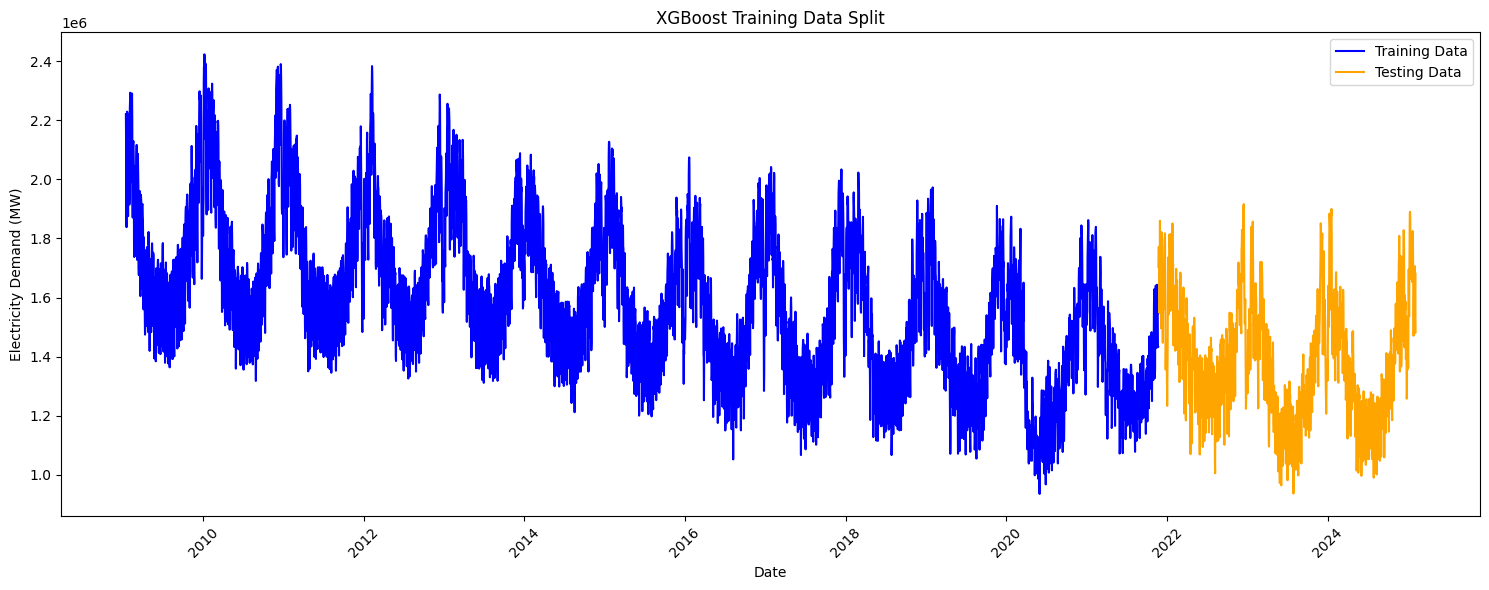

In [36]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# =============================================================================
# Section 1: Data Preprocessing & Aggregation
# =============================================================================
# Convert 'settlement_date' to datetime and aggregate 'tsd' by day
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)

# =============================================================================
# Section 2: Feature Engineering
# =============================================================================
def create_features(df):
    df["day"] = df["ds"].dt.day
    df["month"] = df["ds"].dt.month
    df["year"] = df["ds"].dt.year
    df["day_of_week"] = df["ds"].dt.dayofweek
    df["week_of_year"] = df["ds"].dt.isocalendar().week.astype(int)
    return df

def add_lag_features(df, lags=[1, 2, 3, 7, 14]):
    for lag in lags:
        df[f"lag_{lag}"] = df["y"].shift(lag)
    return df

df_daily = create_features(df_daily)
df_daily = add_lag_features(df_daily)
df_daily = df_daily.dropna().reset_index(drop=True)

# =============================================================================
# Section 3: Split Data into Training and Testing
# =============================================================================
# For example, use 80% of the data for training, 20% for testing
split_idx = int(len(df_daily) * 0.8)
train = df_daily.iloc[:split_idx].copy()
test = df_daily.iloc[split_idx:].copy()

# Define features and target variable (for model training if needed)
feature_cols = ["day", "month", "year", "day_of_week", "week_of_year"] + [f"lag_{lag}" for lag in [1, 2, 3, 7, 14]]
X_train = train[feature_cols]
y_train = train["y"]
X_test = test[feature_cols]
y_test = test["y"]

# =============================================================================
# Section 4: Plot the Training and Testing Splits
# =============================================================================
plt.figure(figsize=(15, 6))
plt.plot(train["ds"], train["y"], label="Training Data", color="blue")
plt.plot(test["ds"], test["y"], label="Testing Data", color="orange")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("XGBoost Training Data Split")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

again we start by dividing historical data into training and test set. 

In [37]:
# =============================================================================
# Section 4: Train XGBoost Model
# =============================================================================
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

# =============================================================================
# Section 5: Predictions & Evaluation
# =============================================================================
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, np.nan, y_test))) * 100

print("Test RMSE: {:.2f}".format(rmse))
print("Test MAPE: {:.2f}%".format(mape))

Test RMSE: 60969.98
Test MAPE: 3.49%


In [ ]:


# --- Step 6: Plot Actual vs. Predicted Values ---
plt.figure(figsize=(14, 7))
plt.plot(test["ds"], y_test, label="Actual", marker="o")
plt.plot(test["ds"], y_pred, label="Predicted", marker="x")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("XGBoost Forecasting: Actual vs. Predicted")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

zooming in on the data it looks like xgboost is doing a good job at predicting the test data. 

<ipython-input-56-9a895d6053b8>:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)


Mean Absolute Percentage Error (MAPE): 3.37%


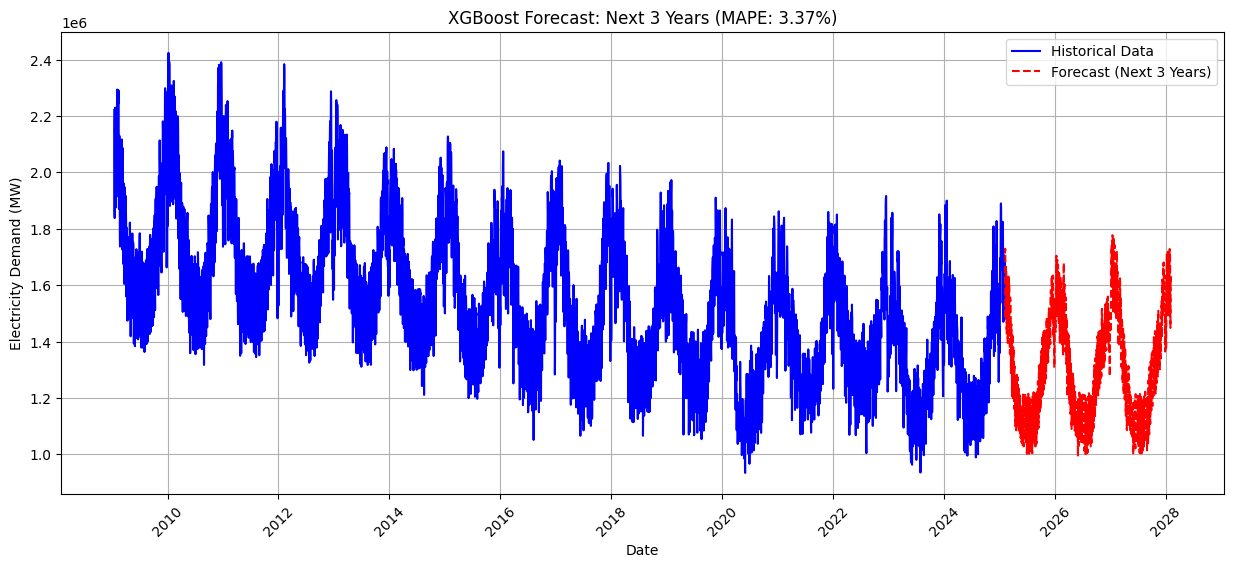

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# =============================================================================
# Section 1: Data Preprocessing
# =============================================================================
# Convert 'settlement_date' to datetime and aggregate demand to daily totals
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)
df_daily.sort_values("ds", inplace=True)

# Add time-based features
df_daily["day"] = df_daily["ds"].dt.day
df_daily["month"] = df_daily["ds"].dt.month
df_daily["year"] = df_daily["ds"].dt.year
df_daily["day_of_week"] = df_daily["ds"].dt.dayofweek
df_daily["week_of_year"] = df_daily["ds"].dt.isocalendar().week

# Create lag features
for lag in [1, 2, 3, 7, 14]:
    df_daily[f"lag_{lag}"] = df_daily["y"].shift(lag)

# Drop NaN values due to lagging
df_daily.dropna(inplace=True)

# Define feature columns
feature_cols = ["day", "month", "year", "day_of_week", "week_of_year"] + [f"lag_{lag}" for lag in [1, 2, 3, 7, 14]]

# =============================================================================
# Section 2: Train-Test Split
# =============================================================================
train_size = int(len(df_daily) * 0.9)  # Use 90% for training, 10% for testing
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

# Extract features and target
X_train, y_train = train[feature_cols], train["y"]
X_test, y_test = test[feature_cols], test["y"]

# =============================================================================
# Section 3: Train XGBoost Model
# =============================================================================
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05)
model.fit(X_train, y_train)

# Predict on test set
y_pred_test = model.predict(X_test)

# =============================================================================
# Section 4: Calculate MAPE
# =============================================================================
mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100  # Convert to percentage
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# =============================================================================
# Section 5: Forecast for the Next 3 Years
# =============================================================================
forecast_horizon = 3 * 365  # Forecast 3 years ahead
df_forecast = df_daily.copy()
last_date = df_forecast["ds"].max()

forecast_dates = []
forecast_values = []

for i in range(forecast_horizon):
    new_date = last_date + pd.Timedelta(days=i + 1)
    
    # Generate features for the new date
    new_features = {
        "day": new_date.day,
        "month": new_date.month,
        "year": new_date.year,
        "day_of_week": new_date.dayofweek,
        "week_of_year": new_date.isocalendar().week,
    }
    
    # Retrieve lag features
    for lag in [1, 2, 3, 7, 14]:
        new_features[f"lag_{lag}"] = df_forecast["y"].iloc[-lag] if len(df_forecast) >= lag else np.nan
    
    # Convert to DataFrame and predict
    new_row = pd.DataFrame([new_features])
    y_pred = model.predict(new_row)[0]
    
    # Store prediction
    forecast_dates.append(new_date)
    forecast_values.append(y_pred)
    
    # Append prediction to df_forecast
    new_row["ds"] = new_date
    new_row["y"] = y_pred
    df_forecast = pd.concat([df_forecast, new_row], ignore_index=True)

# Extract only forecasted portion
forecast_future = pd.DataFrame({"ds": forecast_dates, "y": forecast_values})

# =============================================================================
# Section 6: Plot Results
# =============================================================================
plt.figure(figsize=(15, 6))
plt.plot(df_daily["ds"], df_daily["y"], label="Historical Data", color="blue")
plt.plot(forecast_future["ds"], forecast_future["y"], label="Forecast (Next 3 Years)", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title(f"XGBoost Forecast: Next 3 Years (MAPE: {mape:.2f}%)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


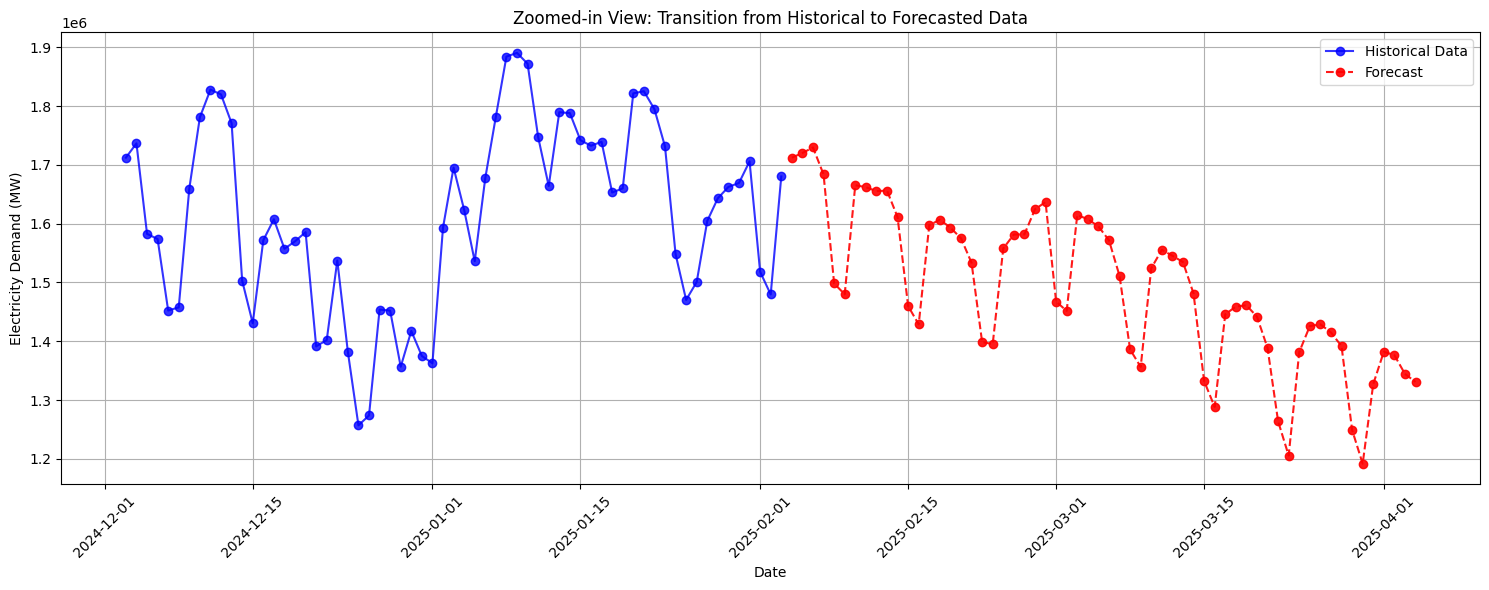

In [57]:
# =============================================================================
# Section 1: Define the Zoom-in Period (Last 2 Months of History + First 2 Months of Forecast)
# =============================================================================
transition_start = df_daily["ds"].max() - pd.DateOffset(months=2)  # Last 2 months of historical data
transition_end = forecast_future["ds"].min() + pd.DateOffset(months=2)  # First 2 months of forecast

# Filter data within the zoomed-in range
historical_zoom = df_daily[(df_daily["ds"] >= transition_start) & (df_daily["ds"] <= transition_end)]
forecast_zoom = forecast_future[(forecast_future["ds"] >= transition_start) & (forecast_future["ds"] <= transition_end)]

# =============================================================================
# Section 2: Plot the Transition Period
# =============================================================================
plt.figure(figsize=(15, 6))

# Plot historical data (Blue)
plt.plot(historical_zoom["ds"], historical_zoom["y"], label="Historical Data", color="blue", marker="o", alpha=0.8)

# Plot forecasted data (Red)
plt.plot(forecast_zoom["ds"], forecast_zoom["y"], label="Forecast", color="red", linestyle="--", marker="o", alpha=0.9)

# Formatting
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("Zoomed-in View: Transition from Historical to Forecasted Data")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:

# Forecast horizon: 3 years (approximately 3 * 365 days)
horizon = 3 * 365  

# Get the last available date in the historical data
last_date = df_daily["ds"].max()

# Make a copy of the historical data; we'll iteratively append future predictions
df_forecast = df_daily.copy()

# -------------------------------
# Section 2: Iterative Forecasting
# -------------------------------
for i in range(1, horizon + 1):
    # Determine the new forecast date
    new_date = last_date + pd.Timedelta(days=i)
    
    # Compute time-based features for the new date
    day = new_date.day
    month = new_date.month
    year = new_date.year
    day_of_week = new_date.dayofweek
    week_of_year = new_date.isocalendar().week
    
    # Retrieve lag features from the most recent 14 days in df_forecast
    recent_values = df_forecast.tail(14)["y"].values
    lag_1 = recent_values[-1] if len(recent_values) >= 1 else np.nan
    lag_2 = recent_values[-2] if len(recent_values) >= 2 else np.nan
    lag_3 = recent_values[-3] if len(recent_values) >= 3 else np.nan
    lag_7 = recent_values[-7] if len(recent_values) >= 7 else np.nan
    lag_14 = recent_values[-14] if len(recent_values) >= 14 else np.nan
    
    # Build a DataFrame with the new features in the same format as training data
    new_row = pd.DataFrame({
        "ds": [new_date],
        "day": [day],
        "month": [month],
        "year": [year],
        "day_of_week": [day_of_week],
        "week_of_year": [week_of_year],
        "lag_1": [lag_1],
        "lag_2": [lag_2],
        "lag_3": [lag_3],
        "lag_7": [lag_7],
        "lag_14": [lag_14]
    })
    
    # Predict the electricity demand using the XGBoost model
    X_new = new_row[feature_cols]
    y_pred = model.predict(X_new)[0]
    
    # Append the prediction to new_row as 'y'
    new_row["y"] = y_pred
    
    # Append new_row to our forecast DataFrame
    df_forecast = pd.concat([df_forecast, new_row], ignore_index=True)

# Extract the forecasted portion (i.e. rows with dates greater than the last historical date)
forecast_future = df_forecast[df_forecast["ds"] > last_date]

# -------------------------------
# Section 3: Plotting the Forecast
# -------------------------------
plt.figure(figsize=(15, 6))
# Plot historical data
plt.plot(df_daily["ds"], df_daily["y"], label="Historical Data", color="blue")
# Plot forecasted data
plt.plot(forecast_future["ds"], forecast_future["y"], label="Forecast (Next 5 Years)", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("XGBoost Forecast: Next 5 Years")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we can see the XGBoost model forcasting 3 years into the future. it looks quite good, gettingt the seasonal pattern but it is significantly more smoothed than the prophet model so alot of the daily patterns are obscured. 

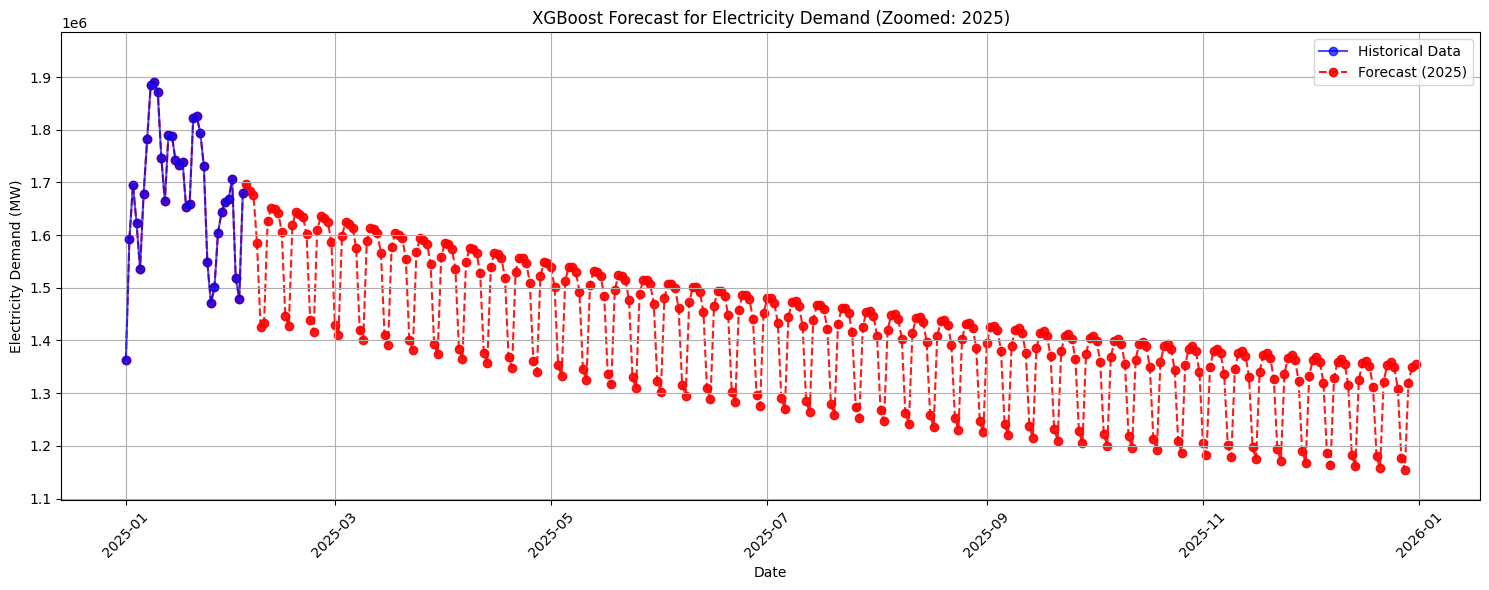

In [50]:
#---------------------------
# Section: Filter Data for 2025
# -------------------------------
zoom_start = pd.Timestamp("2025-01-01")
zoom_end = pd.Timestamp("2025-12-31")

# Ensure historical data and forecasted data are separated correctly
historical_zoom = df_daily[(df_daily["ds"] >= zoom_start) & (df_daily["ds"] <= zoom_end)]
forecast_zoom = df_forecast[(df_forecast["ds"] >= zoom_start) & (df_forecast["ds"] <= zoom_end)]

# -------------------------------
# Section: Plotting the Zoomed Forecast (2025)
# -------------------------------
plt.figure(figsize=(15, 6))

# Plot historical data in blue
plt.plot(historical_zoom["ds"], historical_zoom["y"], 
         label="Historical Data", color="blue", linestyle="-", marker="o", alpha=0.7, zorder=2)

# Plot forecasted data in red
plt.plot(forecast_zoom["ds"], forecast_zoom["y"], 
         label="Forecast (2025)", color="red", linestyle="--", marker="o", alpha=0.9, zorder=1)

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("XGBoost Forecast for Electricity Demand (Zoomed: 2025)")
plt.legend()
plt.xticks(rotation=45)
plt.ylim(min(min(historical_zoom["y"]), min(forecast_zoom["y"])) * 0.95, 
         max(max(historical_zoom["y"]), max(forecast_zoom["y"])) * 1.05)  # Keep Y-scale balanced
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

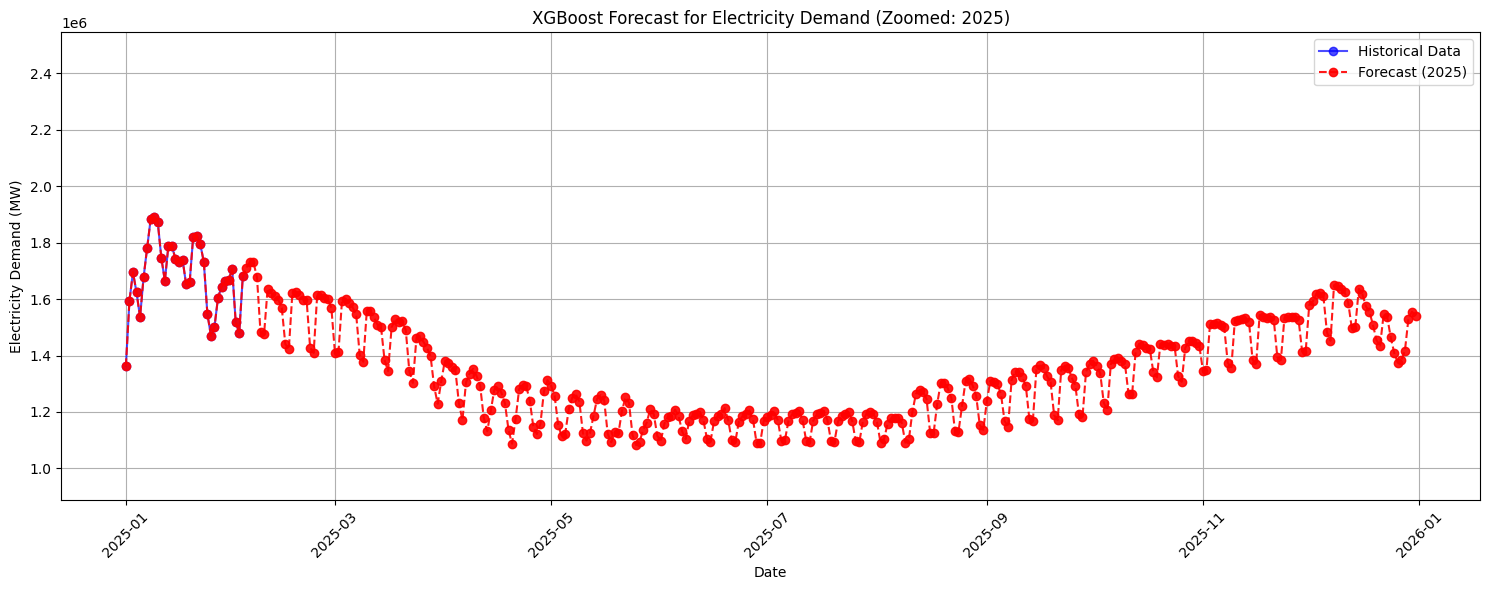

In [40]:
# -------------------------------
# Section: Filter Data for 2025
# -------------------------------
zoom_start = pd.Timestamp("2025-01-01")
zoom_end = pd.Timestamp("2025-12-31")

# Filter historical and forecasted data within the range
historical_zoom = df_daily[(df_daily["ds"] >= zoom_start) & (df_daily["ds"] <= zoom_end)]
forecast_zoom = df_forecast[(df_forecast["ds"] >= zoom_start) & (df_forecast["ds"] <= zoom_end)]

# -------------------------------
# Section: Plotting the Zoomed Forecast (2025)
# -------------------------------
plt.figure(figsize=(15, 6))

# Plot historical data (if any exists within 2025)
plt.plot(historical_zoom["ds"], historical_zoom["y"], 
         label="Historical Data", color="blue", linestyle="-", marker="o", alpha=0.7)

# Plot forecasted data
plt.plot(forecast_zoom["ds"], forecast_zoom["y"], 
         label="Forecast (2025)", color="red", linestyle="--", marker="o", alpha=0.9)

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("XGBoost Forecast for Electricity Demand (Zoomed: 2025)")
plt.legend()
plt.xticks(rotation=45)
plt.ylim(min(df_forecast["y"]) * 0.95, max(df_forecast["y"]) * 1.05)  # Keep the Y-scale consistent
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


zooming in we can see it is significantly smoothed in the forcast area but this is to be expected. 

Conclusion:

The forecasting experiments showed that Prophet produced high quality predictions, effectively capturing the underlying seasonality of the National Grid data. This suggests that when dealing with strong and stable seasonal patterns, Prophet's built-in seasonal decomposition, trend modeling, and holiday adjustments offer a robust and interpretable forecasting approach.

In contrast, the XGBoost model struggled to recreate the seasonality without extensive feature engineering. This indicates that while XGBoost is a powerful, flexible algorithm, its performance on time series data with pronounced seasonal cycles heavily depends on how well the seasonal patterns are encoded into the features.

Next Steps to Improve XGBoost Forecasting:

Enhanced Feature Engineering:
Consider adding more sophisticated seasonal features, such as Fourier series terms, to better capture the periodic patterns in the data.

Hyperparameter Tuning:
Experiment with tuning XGBoost’s parameters (e.g., learning rate, max depth, number of estimators) using grid search or Bayesian optimization to optimize its performance.

Hybrid Models:
Explore combining Prophet’s forecasts with XGBoost predictions (ensemble methods) to leverage the strengths of both approaches.

Incorporate External Variables:
Adding additional regressors like weather data or economic indicators might help XGBoost capture more nuanced patterns that drive electricity demand.


Overall, the results highlight the importance of choosing a model that aligns with the characteristics of the data. Prophet's success here suggests it is well-suited for datasets with clear seasonal trends, while XGBoost could be improved with further targeted feature engineering and model tuning.

LSTM Deep Learning Model 

now we can use a neural network deep learning model which is not as often applied to this type of time series analysis as it is more compelex and favours datasets larger than this one. but we shall see what results an exploratory test will give. 

the deep learning model works by batching the data and running it through several layers of processsing called epochs. we can start of with a model with 10 epoch which can run in about 20 seconds , then move onto a 50 epoch and 100 epoch run for more accurate prediction. 

interstingly the DL model seems to give a different forcast every time the code is run, this makes sense due to the stochastic nature of neural networks. Neural networks start with random weights, which can lead to slight variations in results after training. when using large enough data sets with enough batches to average out the difference will not be noticable but with this dataset it can cause issues making it a less desirable option than the machine datasets 

In [ ]:
# 10 epochs 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Section 1: Data Preprocessing
# -----------------------------
# Convert 'settlement_date' to datetime and aggregate data to daily totals
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)
df_daily.sort_values("ds", inplace=True)

# -----------------------------
# Section 2: Data Scaling & Sequence Creation
# -----------------------------
# Scale the target values to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data = df_daily["y"].values.reshape(-1, 1)
data_scaled = scaler.fit_transform(data)

# Function to create input sequences and corresponding targets
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(data_scaled, window_size)

# Reshape X to be [samples, timesteps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# -----------------------------
# Section 3: Train-Test Split
# -----------------------------
# Use the last 10% of the sequences as test data
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# -----------------------------
# Section 4: Build and Train LSTM Model
# -----------------------------
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# -----------------------------
# Section 5: Forecasting and Plotting
# -----------------------------
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values back to original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# For plotting, extract the corresponding dates from the original df_daily.
# Note: Because we lose 'window_size' days when creating sequences, adjust the date index.
plot_dates = df_daily["ds"].values[window_size + train_size : window_size + train_size + len(y_test_inv)]

plt.figure(figsize=(12, 6))
plt.plot(plot_dates, y_test_inv, label="Actual")
plt.plot(plot_dates, y_pred_inv, label="Predicted", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Forecasting of Electricity Demand (10 Epoch Test Set)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Epoch 1/10


<ipython-input-41-f46ec29e38c9>:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0633 - val_loss: 0.0062
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0080 - val_loss: 0.0057
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0064 - val_loss: 0.0043
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 9/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 10/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0039 - val_loss: 0.0030
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [42]:
# Compute Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

# Display MAPE value
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 4.73%


the training and percentage error look good, how will it apply it to forcasting. 

Epoch 1/50


<ipython-input-60-c7aa7dd26369>:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0620
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0073
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0069
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0071
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0068
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0055
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0045
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0044
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0031
Epoch 10/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0026
Epoch 11/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0022
Epoch 12/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0022
Epoch 13/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0020
Epoch 14/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0020
Epoch 15/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step 

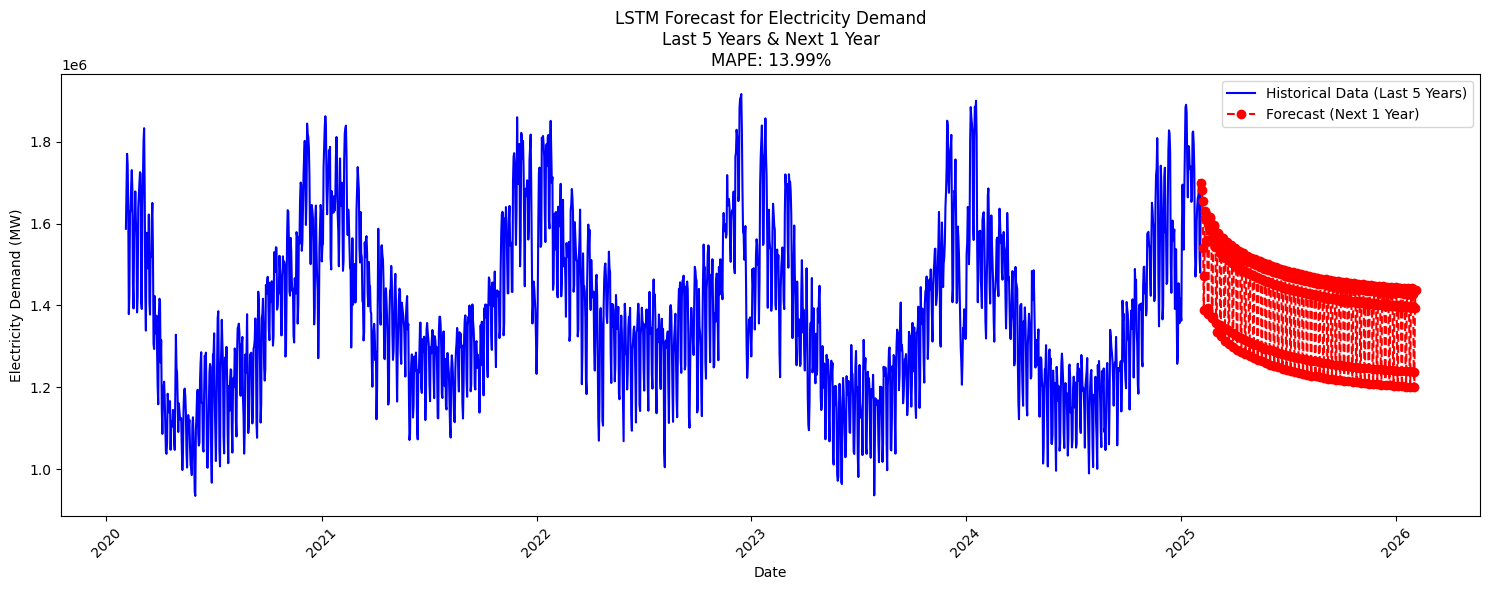

In [60]:
from sklearn.metrics import mean_absolute_error

# =============================================================================
# Section 1: Data Preprocessing & Aggregation
# =============================================================================
# Convert 'settlement_date' to datetime and aggregate 'tsd' by day
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)
df_daily.sort_values("ds", inplace=True)

# =============================================================================
# Section 2: Scaling & Sequence Creation for LSTM
# =============================================================================
scaler = MinMaxScaler(feature_range=(0, 1))
data = df_daily["y"].values.reshape(-1, 1)
data_scaled = scaler.fit_transform(data)

def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(data_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, y_train = X, y  # Training on entire historical data

# =============================================================================
# Section 3: Build and Train LSTM Model
# =============================================================================
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# =============================================================================
# Section 4: Iterative Forecasting for 1 Year (365 days)
# =============================================================================
horizon = 365  # Forecast horizon in days
df_forecast = df_daily.copy()  # Start with historical data

# Iteratively forecast one day at a time
for i in range(horizon):
    new_date = df_forecast["ds"].iloc[-1] + pd.Timedelta(days=1)
    
    # Get last 'window_size' values
    last_window = df_forecast["y"].values[-window_size:]
    
    # Scale values
    last_window_scaled = scaler.transform(last_window.reshape(-1, 1))
    last_window_scaled = last_window_scaled.reshape((1, window_size, 1))
    
    # Predict next day's demand
    pred_scaled = model.predict(last_window_scaled)[0][0]
    pred = scaler.inverse_transform(np.array([[pred_scaled]]))[0][0]
    
    # Append new prediction
    new_row = pd.DataFrame({"ds": [new_date], "y": [pred]})
    df_forecast = pd.concat([df_forecast, new_row], ignore_index=True)

# Extract forecasted data
historical_last_date = df_daily["ds"].max()
forecast_future = df_forecast[df_forecast["ds"] > historical_last_date]

# =============================================================================
# Section 5: MAPE Calculation (Fixed)
# =============================================================================
# Ensure actual values are available for comparison
comparison_period = df_daily[df_daily["ds"] > historical_last_date - pd.DateOffset(days=horizon)]
actual_values = comparison_period["y"].dropna().values

# Ensure predicted values match actual values in length
predicted_values = forecast_future["y"].values[:len(actual_values)]

if len(actual_values) == len(predicted_values) and len(actual_values) > 0:
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    print(f"📊 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
else:
    mape = np.nan
    print("⚠️ MAPE Calculation Error: Length mismatch between actual and predicted values.")

# =============================================================================
# Section 6: Plot Historical Data & 1-Year Forecast
# =============================================================================
# Get last 5 years of historical data
start_date = df_daily["ds"].max() - pd.DateOffset(years=5)
historical_subset = df_daily[df_daily["ds"] >= start_date]

plt.figure(figsize=(15, 6))
plt.plot(historical_subset["ds"], historical_subset["y"], label="Historical Data (Last 5 Years)", color="blue")
plt.plot(forecast_future["ds"], forecast_future["y"], label="Forecast (Next 1 Year)", color="red", linestyle="--", marker="o")

# Add MAPE to plot title
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title(f"LSTM Forecast for Electricity Demand\nLast 5 Years & Next 1 Year\nMAPE: {mape:.2f}%")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Epoch 1/50


<ipython-input-43-210945e846d4>:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0490
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0073
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0071
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0068
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0066
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0065
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0064
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0051
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0047
Epoch 10/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0043
Epoch 11/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0043
Epoch 12/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0041
Epoch 13/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0041
Epoch 14/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0037
Epoch 15/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step 

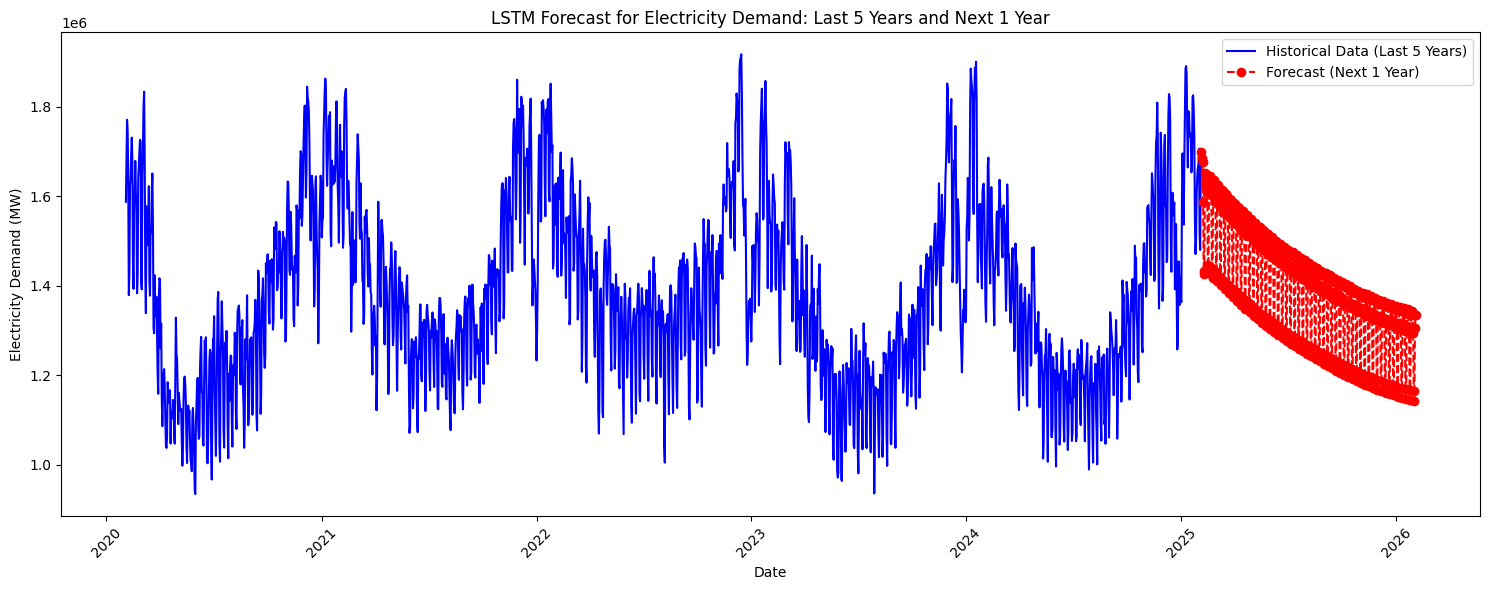

In [43]:
# 50 epoch 
# =============================================================================
# Section 1: Data Preprocessing & Aggregation
# =============================================================================
# Convert 'settlement_date' to datetime and aggregate 'tsd' by day
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)
df_daily.sort_values("ds", inplace=True)

# =============================================================================
# Section 2: Scaling & Sequence Creation for LSTM
# =============================================================================
scaler = MinMaxScaler(feature_range=(0, 1))
data = df_daily["y"].values.reshape(-1, 1)
data_scaled = scaler.fit_transform(data)

def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(data_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, y_train = X, y  # training on entire historical data

# =============================================================================
# Section 3: Build and Train LSTM Model
# =============================================================================
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# =============================================================================
# Section 4: Iterative Forecasting for 1 Year (365 days)
# =============================================================================
horizon = 365  # Forecast horizon in days
df_forecast = df_daily.copy()  # Start with historical data

# Iteratively forecast one day at a time, updating the last date each iteration
for i in range(horizon):
    # Get the new date as the last date in df_forecast plus one day
    new_date = df_forecast["ds"].iloc[-1] + pd.Timedelta(days=1)
    
    # Get the last 'window_size' actual/forecasted values
    last_window = df_forecast["y"].values[-window_size:]
    
    # Scale these values
    last_window_scaled = scaler.transform(last_window.reshape(-1, 1))
    last_window_scaled = last_window_scaled.reshape((1, window_size, 1))
    
    # Predict next day's scaled value using the LSTM model
    pred_scaled = model.predict(last_window_scaled)[0][0]
    
    # Inverse transform to get the prediction in original scale
    pred = scaler.inverse_transform(np.array([[pred_scaled]]))[0][0]
    
    # Append the new prediction to df_forecast
    new_row = pd.DataFrame({"ds": [new_date], "y": [pred]})
    df_forecast = pd.concat([df_forecast, new_row], ignore_index=True)

# Extract only the forecasted portion (dates after the last historical date)
historical_last_date = df_daily["ds"].max()
forecast_future = df_forecast[df_forecast["ds"] > historical_last_date]

# =============================================================================
# Section 5: Plot Historical Data (Last 5 Years) and 1-Year Forecast
# =============================================================================
# Get the start date for the last 5 years
start_date = df_daily["ds"].max() - pd.DateOffset(years=5)
historical_subset = df_daily[df_daily["ds"] >= start_date]

plt.figure(figsize=(15, 6))
plt.plot(historical_subset["ds"], historical_subset["y"], label="Historical Data (Last 5 Years)", color="blue")
plt.plot(forecast_future["ds"], forecast_future["y"], label="Forecast (Next 1 Year)", color="red", linestyle="--", marker="o")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Forecast for Electricity Demand: Last 5 Years and Next 1 Year")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
print(MAPE)

NameError: name 'MAPE' is not defined

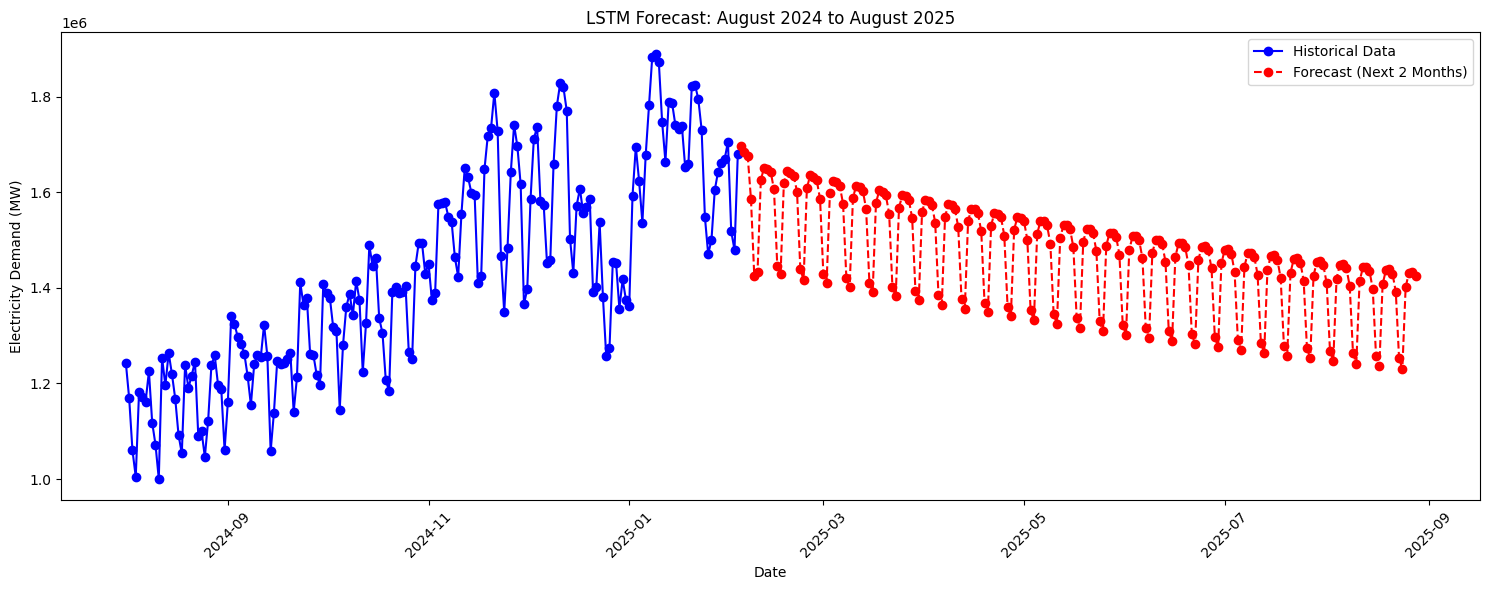

In [44]:
# =============================================================================
# Section 6: Plot Zoomed-in View for Current & Next Month
# =============================================================================

# Define adjustable date parameters
today = pd.Timestamp.today()
start_zoom = pd.Timestamp(year=2024, month=8, day=1)  # Start of January
end_zoom = pd.Timestamp(year=2025, month=8, day=28) 

# Filter historical and forecast data within the selected range
historical_zoomed = df_daily[(df_daily["ds"] >= start_zoom) & (df_daily["ds"] <= end_zoom)]
forecast_zoomed = forecast_future[(forecast_future["ds"] >= start_zoom) & (forecast_future["ds"] <= end_zoom)]

# Plot Zoomed-in Forecast
plt.figure(figsize=(15, 6))
plt.plot(historical_zoomed["ds"], historical_zoomed["y"], label="Historical Data", color="blue", marker="o")
plt.plot(forecast_zoomed["ds"], forecast_zoomed["y"], label="Forecast (Next 2 Months)", color="red", linestyle="--", marker="o")

plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title(f"LSTM Forecast: {start_zoom.strftime('%B %Y')} to {end_zoom.strftime('%B %Y')}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-45-84d65377cad6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_2024["ds_numeric"] = actual_2024["ds"].astype(np.int64) // 10**9
<ipython-input-45-84d65377cad6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_2025["ds_numeric"] = actual_2025["ds"].astype(np.int64) // 10**9
<ipython-input-45-84d65377cad6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

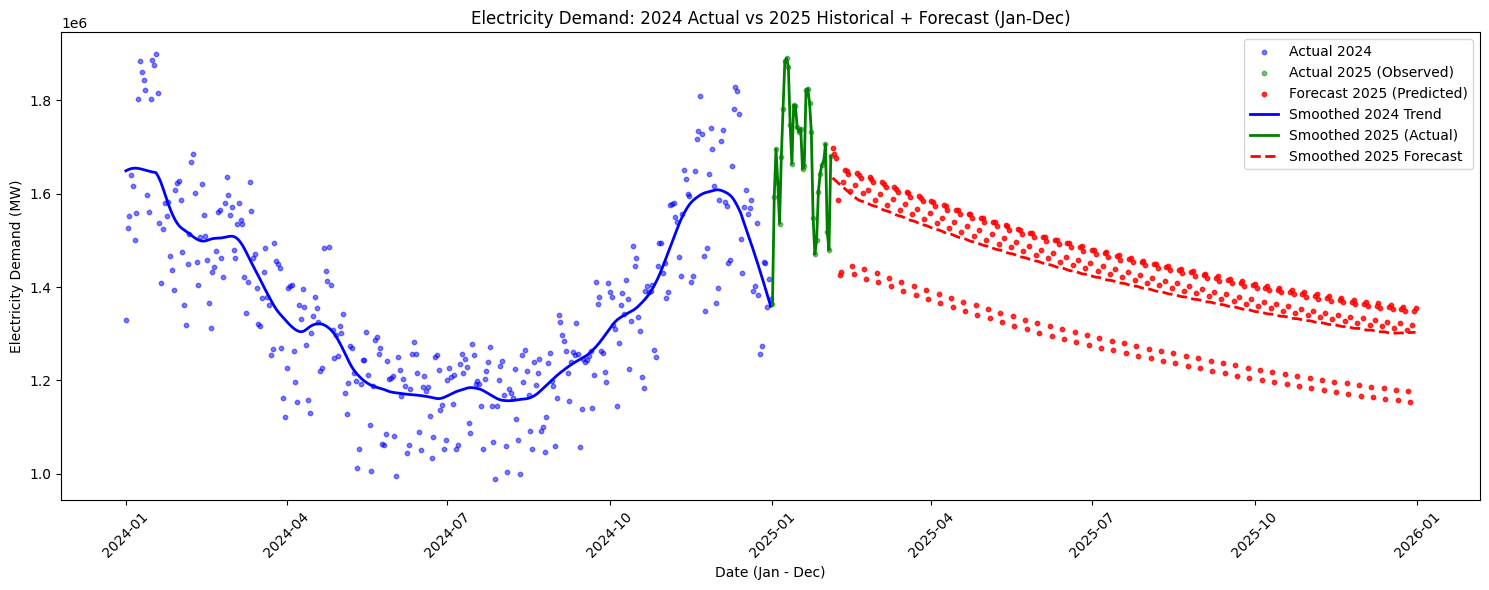

In [45]:

from statsmodels.nonparametric.smoothers_lowess import lowess

# =============================================================================
# Section 7: Overlay January - December 2024 vs. 2025 (Historical + Forecast)
# =============================================================================

# Define the date ranges for full-year (Jan-Dec) for both 2024 and 2025
jan_dec_2024 = (pd.Timestamp(year=2024, month=1, day=1), pd.Timestamp(year=2024, month=12, day=31))
jan_dec_2025 = (pd.Timestamp(year=2025, month=1, day=1), pd.Timestamp(year=2025, month=12, day=31))

# Filter data for the full year (January - December) for 2024 and 2025
actual_2024 = df_daily[(df_daily["ds"] >= jan_dec_2024[0]) & (df_daily["ds"] <= jan_dec_2024[1])]
actual_2025 = df_daily[(df_daily["ds"] >= jan_dec_2025[0]) & (df_daily["ds"] <= jan_dec_2025[1])]
forecast_2025 = forecast_future[(forecast_future["ds"] >= jan_dec_2025[0]) & (forecast_future["ds"] <= jan_dec_2025[1])]

# Convert datetime to numerical values for LOWESS smoothing
actual_2024["ds_numeric"] = actual_2024["ds"].astype(np.int64) // 10**9
actual_2025["ds_numeric"] = actual_2025["ds"].astype(np.int64) // 10**9
forecast_2025["ds_numeric"] = forecast_2025["ds"].astype(np.int64) // 10**9

# Apply LOWESS smoothing for trend lines
lowess_2024 = lowess(actual_2024["y"], actual_2024["ds_numeric"], frac=0.1)
lowess_2025_actual = lowess(actual_2025["y"], actual_2025["ds_numeric"], frac=0.1)
lowess_2025_forecast = lowess(forecast_2025["y"], forecast_2025["ds_numeric"], frac=0.1)

# Create the plot
plt.figure(figsize=(15, 6))

# Scatter plots for raw data points
plt.scatter(actual_2024["ds"], actual_2024["y"], label="Actual 2024", color="blue", alpha=0.5, s=10)
plt.scatter(actual_2025["ds"], actual_2025["y"], label="Actual 2025 (Observed)", color="green", alpha=0.5, s=10)
plt.scatter(forecast_2025["ds"], forecast_2025["y"], label="Forecast 2025 (Predicted)", color="red", alpha=0.8, s=10)

# Smoothed trend lines
plt.plot(pd.to_datetime(lowess_2024[:, 0], unit="s"), lowess_2024[:, 1], color="blue", linewidth=2, label="Smoothed 2024 Trend")
plt.plot(pd.to_datetime(lowess_2025_actual[:, 0], unit="s"), lowess_2025_actual[:, 1], color="green", linewidth=2, label="Smoothed 2025 (Actual)")
plt.plot(pd.to_datetime(lowess_2025_forecast[:, 0], unit="s"), lowess_2025_forecast[:, 1], color="red", linestyle="--", linewidth=2, label="Smoothed 2025 Forecast")

# Formatting
plt.xlabel("Date (Jan - Dec)")
plt.ylabel("Electricity Demand (MW)")
plt.title("Electricity Demand: 2024 Actual vs 2025 Historical + Forecast (Jan-Dec)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


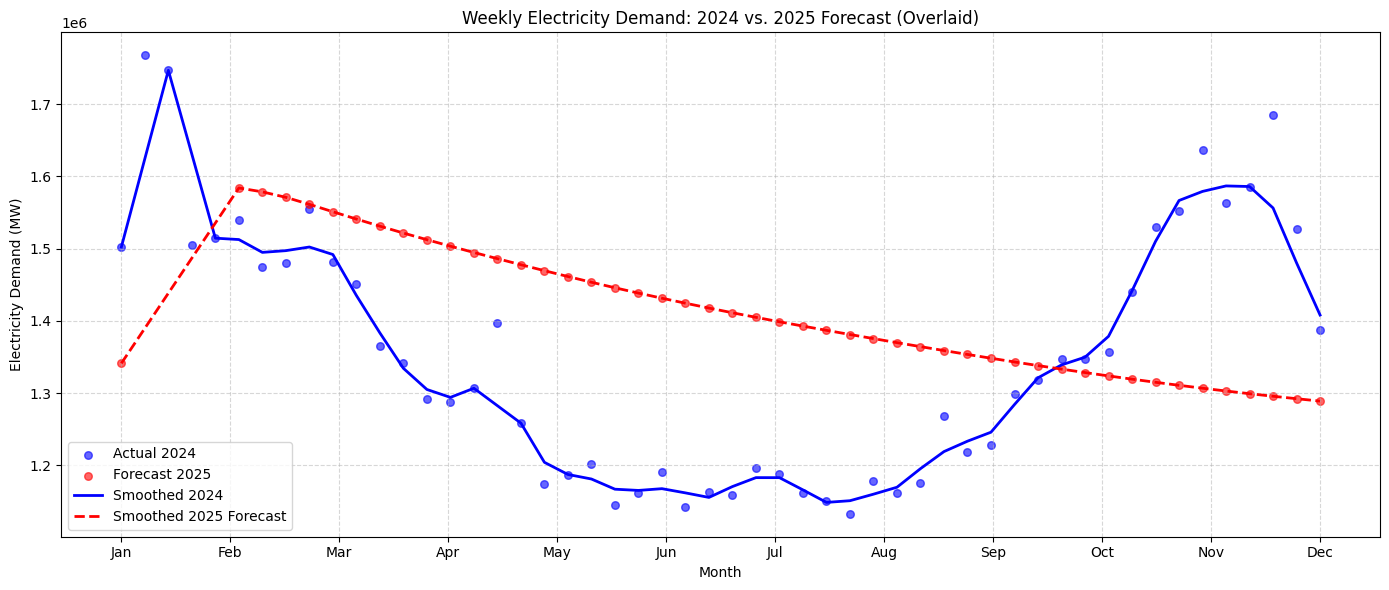

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

# =============================================================================
# Section 7: Compare 2024 vs. 2025 (Overlayed on Same Timeline)
# =============================================================================

# Extract January - December for both years
df_2024 = df_daily[(df_daily["ds"] >= "2024-01-01") & (df_daily["ds"] <= "2024-12-31")].copy()
df_2025_actual = df_daily[(df_daily["ds"] >= "2025-01-01") & (df_daily["ds"] <= "2025-12-31")].copy()
df_2025_forecast = forecast_future[(forecast_future["ds"] >= "2025-01-01") & (forecast_future["ds"] <= "2025-12-31")].copy()

# Add "Week of Year" column
df_2024["Week"] = df_2024["ds"].dt.isocalendar().week
df_2025_forecast["Week"] = df_2025_forecast["ds"].dt.isocalendar().week

# Aggregate data by week (ensuring exactly 1 point per week)
df_2024_avg = df_2024.groupby("Week")["y"].mean().reset_index()
df_2025_forecast_avg = df_2025_forecast.groupby("Week")["y"].mean().reset_index()

# Apply LOWESS smoothing for better trend visibility
lowess_2024 = lowess(df_2024_avg["y"], df_2024_avg["Week"], frac=0.1)
lowess_2025_forecast = lowess(df_2025_forecast_avg["y"], df_2025_forecast_avg["Week"], frac=0.1)

# =============================================================================
# Plot: 2024 Actual vs 2025 Forecast (Overlayed on the Same Timeline)
# =============================================================================
plt.figure(figsize=(14, 6))

# Scatter plots for weekly averages
plt.scatter(df_2024_avg["Week"], df_2024_avg["y"], color="blue", label="Actual 2024", alpha=0.6, s=30)
plt.scatter(df_2025_forecast_avg["Week"], df_2025_forecast_avg["y"], color="red", label="Forecast 2025", alpha=0.6, s=30)

# Smoothed trend lines
plt.plot(df_2024_avg["Week"], lowess_2024[:, 1], color="blue", linewidth=2, label="Smoothed 2024")
plt.plot(df_2025_forecast_avg["Week"], lowess_2025_forecast[:, 1], color="red", linestyle="--", linewidth=2, label="Smoothed 2025 Forecast")

# Formatting
plt.xlabel("Month")
plt.ylabel("Electricity Demand (MW)")
plt.title("Weekly Electricity Demand: 2024 vs. 2025 Forecast (Overlaid)")
plt.xticks(np.linspace(1, 52, num=12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [47]:
# =============================================================================
# Section 1: Data Preprocessing & Aggregation
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Convert 'settlement_date' to datetime and aggregate 'tsd' by day
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)
df_daily.sort_values("ds", inplace=True)

# Add seasonal features
df_daily["day_of_week"] = df_daily["ds"].dt.dayofweek  # Monday=0, Sunday=6
df_daily["month"] = df_daily["ds"].dt.month
df_daily["year"] = df_daily["ds"].dt.year
df_daily["week_of_year"] = df_daily["ds"].dt.isocalendar().week.astype(int)

# =============================================================================
# Section 2: Scaling & Sequence Creation for LSTM
# =============================================================================
# Scale target variable (y)
scaler_y = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_y.fit_transform(df_daily["y"].values.reshape(-1, 1))

# Scale additional temporal features
scaler_features = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(df_daily[["day_of_week", "month", "week_of_year"]])

# Combine scaled features into a single dataset
full_data_scaled = np.hstack([data_scaled, features_scaled])

# Function to create sequences for LSTM input
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq_x = data[i:i+window_size, :]  # Past data window
        seq_y = data[i+window_size, 0]  # Target: future demand
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(full_data_scaled, window_size)

# Reshape X to be [samples, timesteps, features] for BiLSTM
X = X.reshape((X.shape[0], X.shape[1], full_data_scaled.shape[1]))

# =============================================================================
# Section 3: Train-Test Split
# =============================================================================
# Use last 10% of data for testing
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# =============================================================================
# Section 4: Build & Train Bidirectional LSTM Model
# =============================================================================
model = Sequential([
    Bidirectional(LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, X.shape[2]))),
    Dropout(0.2),
    Bidirectional(LSTM(50, activation='relu')),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# =============================================================================
# Section 5: Predict on Test Set and Visualize Results
# =============================================================================
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values back to original scale
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Get corresponding test dates
plot_dates = df_daily["ds"].values[-len(y_test_inv):]

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(plot_dates, y_test_inv, label="Actual", color="blue")
plt.plot(plot_dates, y_pred_inv, label="Predicted", linestyle="--", color="red")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("Bidirectional LSTM: Actual vs Predicted (Test Set)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Epoch 1/50


<ipython-input-47-f5b412de3249>:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 0.0171 - val_loss: 0.0043
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 3/50
  1/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0074

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import timedelta

# =============================================================================
# Section 1: Data Preprocessing & Aggregation
# =============================================================================
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)
df_daily.sort_values("ds", inplace=True)

# Add time-based features
df_daily["day_of_week"] = df_daily["ds"].dt.dayofweek  # Monday=0, Sunday=6
df_daily["month"] = df_daily["ds"].dt.month
df_daily["week_of_year"] = df_daily["ds"].dt.isocalendar().week.astype(int)

# =============================================================================
# Section 2: Scaling & Sequence Creation
# =============================================================================
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

# Scale the target variable (electricity demand)
df_daily["y_scaled"] = scaler_y.fit_transform(df_daily["y"].values.reshape(-1, 1))

# Scale the seasonal features
seasonal_features = df_daily[["day_of_week", "month", "week_of_year"]]
df_daily[["day_of_week_scaled", "month_scaled", "week_of_year_scaled"]] = scaler_features.fit_transform(seasonal_features)

# Combine all features
features = ["y_scaled", "day_of_week_scaled", "month_scaled", "week_of_year_scaled"]
df_scaled = df_daily[features].values

# Function to create sequences for LSTM
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq_x = data[i:i+window_size, :]  # Using all features
        seq_y = data[i+window_size, 0]  # Predict only the demand
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(df_scaled, window_size)

# Reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# =============================================================================
# Section 3: Build & Train LSTM Model
# =============================================================================
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict electricity demand
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1)

# =============================================================================
# Section 4: Plot Training Results
# =============================================================================
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Training Loss Over Epochs")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import timedelta

# Load and preprocess data
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True, infer_datetime_format=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)
df_daily.sort_values("ds", inplace=True)

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
df_daily["y_scaled"] = scaler.fit_transform(df_daily["y"].values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Define sequence window size
window_size = 60
X, y = create_sequences(df_daily["y_scaled"].values, window_size)

# Reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and test sets (90% train, 10% test)
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# Build the LSTM model 20 epochs
model = Sequential([
    LSTM(100, activation="relu", return_sequences=True, input_shape=(window_size, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform predictions and actual values back to original scale
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

# Get the corresponding dates from df_daily for plotting
train_dates = df_daily["ds"][window_size:window_size+len(y_train)]
test_dates = df_daily["ds"][window_size+len(y_train):window_size+len(y_train)+len(y_test)]

# Plot Training vs Testing Data
plt.figure(figsize=(15, 6))
plt.plot(train_dates, y_train_inv, label="Training Actual", color="blue")
plt.plot(train_dates, y_train_pred_inv, label="Training Predicted", color="cyan", linestyle="--")
plt.plot(test_dates, y_test_inv, label="Testing Actual", color="black")
plt.plot(test_dates, y_test_pred_inv, label="Testing Predicted", color="red", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Model: Training vs. Testing Predictions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# Forecast for the next 180 days
forecast_horizon = 180
forecasted_dates = []
forecasted_values = []

last_window = df_daily["y_scaled"].values[-window_size:]  # Start with last known data
last_window = last_window.reshape((1, window_size, 1))

for i in range(forecast_horizon):
    new_date = df_daily["ds"].max() + timedelta(days=i+1)
    
    # Predict next day's demand
    pred_scaled = model.predict(last_window)[0][0]
    pred = scaler.inverse_transform([[pred_scaled]])[0][0]  # Convert back to MW
    
    # Store results
    forecasted_dates.append(new_date)
    forecasted_values.append(pred)
    
    # Update last window (shift & add new prediction)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred_scaled

# Create DataFrame for forecast
forecast_df = pd.DataFrame({"ds": forecasted_dates, "y": forecasted_values})

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(df_daily["ds"], df_daily["y"], label="Historical Data", color="blue")
plt.plot(forecast_df["ds"], forecast_df["y"], label="Forecast (Next 6 Months)", color="red", linestyle="--", marker="o")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Forecast for Electricity Demand: Next 6 Months")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Build the LSTM model 50 epochs
model = Sequential([
    LSTM(100, activation="relu", return_sequences=True, input_shape=(window_size, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform predictions and actual values back to original scale
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

# Get the corresponding dates from df_daily for plotting
train_dates = df_daily["ds"][window_size:window_size+len(y_train)]
test_dates = df_daily["ds"][window_size+len(y_train):window_size+len(y_train)+len(y_test)]

# Plot Training vs Testing Data
plt.figure(figsize=(15, 6))
plt.plot(train_dates, y_train_inv, label="Training Actual", color="blue")
plt.plot(train_dates, y_train_pred_inv, label="Training Predicted", color="cyan", linestyle="--")
plt.plot(test_dates, y_test_inv, label="Testing Actual", color="black")
plt.plot(test_dates, y_test_pred_inv, label="Testing Predicted", color="red", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Model: Training vs. Testing Predictions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# Forecast for the next 180 days
forecast_horizon = 180
forecasted_dates = []
forecasted_values = []

last_window = df_daily["y_scaled"].values[-window_size:]  # Start with last known data
last_window = last_window.reshape((1, window_size, 1))

for i in range(forecast_horizon):
    new_date = df_daily["ds"].max() + timedelta(days=i+1)
    
    # Predict next day's demand
    pred_scaled = model.predict(last_window)[0][0]
    pred = scaler.inverse_transform([[pred_scaled]])[0][0]  # Convert back to MW
    
    # Store results
    forecasted_dates.append(new_date)
    forecasted_values.append(pred)
    
    # Update last window (shift & add new prediction)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred_scaled

# Create DataFrame for forecast
forecast_df = pd.DataFrame({"ds": forecasted_dates, "y": forecasted_values})

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(df_daily["ds"], df_daily["y"], label="Historical Data", color="blue")
plt.plot(forecast_df["ds"], forecast_df["y"], label="Forecast (Next 6 Months)", color="red", linestyle="--", marker="o")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Forecast for Electricity Demand: Next 6 Months")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Build the LSTM model 100 epochs
model = Sequential([
    LSTM(100, activation="relu", return_sequences=True, input_shape=(window_size, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform predictions and actual values back to original scale
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

# Get the corresponding dates from df_daily for plotting
train_dates = df_daily["ds"][window_size:window_size+len(y_train)]
test_dates = df_daily["ds"][window_size+len(y_train):window_size+len(y_train)+len(y_test)]

# Plot Training vs Testing Data
plt.figure(figsize=(15, 6))
plt.plot(train_dates, y_train_inv, label="Training Actual", color="blue")
plt.plot(train_dates, y_train_pred_inv, label="Training Predicted", color="cyan", linestyle="--")
plt.plot(test_dates, y_test_inv, label="Testing Actual", color="black")
plt.plot(test_dates, y_test_pred_inv, label="Testing Predicted", color="red", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Model: Training vs. Testing Predictions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# =============================================================================
# Section 1: Data Preprocessing & Feature Engineering
# =============================================================================
df["settlement_date"] = pd.to_datetime(df["settlement_date"], dayfirst=True)
df_daily = df.groupby("settlement_date")["tsd"].sum().reset_index()
df_daily.rename(columns={"settlement_date": "ds", "tsd": "y"}, inplace=True)
df_daily.sort_values("ds", inplace=True)

# Add time-based features to improve seasonality handling
df_daily["day_of_week"] = df_daily["ds"].dt.dayofweek  # 0=Monday, 6=Sunday
df_daily["month"] = df_daily["ds"].dt.month
df_daily["year"] = df_daily["ds"].dt.year
df_daily["week_of_year"] = df_daily["ds"].dt.isocalendar().week.astype(int)

# Scale target variable (y)
scaler_y = MinMaxScaler(feature_range=(0, 1))
df_daily["y_scaled"] = scaler_y.fit_transform(df_daily["y"].values.reshape(-1, 1))

# =============================================================================
# Section 2: Prepare LSTM Training Data (Sequence Creation)
# =============================================================================
window_size = 30  # How many days of past data to use for prediction

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

data_scaled = df_daily["y_scaled"].values.reshape(-1, 1)
X, y = create_sequences(data_scaled, window_size)

# Reshape for LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split Data into Training (90%) and Testing (10%)
split_idx = int(len(X) * 0.9)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# =============================================================================
# Section 3: Build and Train the LSTM Model
# =============================================================================
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.01),  # Reduce overfitting
    LSTM(30, activation="relu"),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train with only 20 epochs
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# =============================================================================
# Section 4: Evaluate Model and Predict on Test Set
# =============================================================================
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform predictions and actual values back to MW scale
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)

# Get corresponding dates for plotting
train_dates = df_daily["ds"][window_size:window_size+len(y_train)]
test_dates = df_daily["ds"][window_size+len(y_train):window_size+len(y_train)+len(y_test)]

# Plot Training vs. Testing Predictions
plt.figure(figsize=(15, 6))
plt.plot(train_dates, y_train_inv, label="Training Actual", color="blue")
plt.plot(train_dates, y_train_pred_inv, label="Training Predicted", color="cyan", linestyle="--")
plt.plot(test_dates, y_test_inv, label="Testing Actual", color="black")
plt.plot(test_dates, y_test_pred_inv, label="Testing Predicted", color="red", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Model: Training vs. Testing Predictions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# Section 5: Forecast for Next 365 Days
# =============================================================================
forecast_horizon = 365
forecasted_dates = []
forecasted_values = []

last_window = df_daily["y_scaled"].values[-window_size:].reshape((1, window_size, 1))

for i in range(forecast_horizon):
    new_date = df_daily["ds"].max() + timedelta(days=i+1)

    # Predict next day's demand
    pred_scaled = model.predict(last_window)[0][0]
    pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]  # Convert back to MW

    # Store results
    forecasted_dates.append(new_date)
    forecasted_values.append(pred)

    # Update last window (shift & add new prediction)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred_scaled

# Create DataFrame for forecast
forecast_df = pd.DataFrame({"ds": forecasted_dates, "y": forecasted_values})

# =============================================================================
# Section 6: Plot Forecast vs. Historical Data
# =============================================================================
plt.figure(figsize=(15, 6))
plt.plot(df_daily["ds"], df_daily["y"], label="Historical Data", color="blue")
plt.plot(forecast_df["ds"], forecast_df["y"], label="Forecast (Next 1 Year)", color="red", linestyle="--", marker="o")

plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Forecast for Electricity Demand: Next 1 Year")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Forecast for the next 365 days
forecast_horizon = 365
forecasted_dates = []
forecasted_values = []

last_window = df_daily["y_scaled"].values[-window_size:]  # Start with last known data
last_window = last_window.reshape((1, window_size, 1))

for i in range(forecast_horizon):
    new_date = df_daily["ds"].max() + timedelta(days=i+1)
    
    # Predict next day's demand
    pred_scaled = model.predict(last_window)[0][0]
    pred = scaler.inverse_transform([[pred_scaled]])[0][0]  # Convert back to MW
    
    # Store results
    forecasted_dates.append(new_date)
    forecasted_values.append(pred)
    
    # Update last window (shift & add new prediction)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred_scaled

# Create DataFrame for forecast
forecast_df = pd.DataFrame({"ds": forecasted_dates, "y": forecasted_values})

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(df_daily["ds"], df_daily["y"], label="Historical Data", color="blue")
plt.plot(forecast_df["ds"], forecast_df["y"], label="Forecast (Next 6 Months)", color="red", linestyle="--", marker="o")
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Forecast for Electricity Demand: Next 6 Months")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from datetime import timedelta

# Forecast for the next 3 years (2025-2027)
forecast_horizon = 365 * 3  # 3 years
forecasted_dates = []
forecasted_values = []

# Start with last known data
last_window = df_daily["y_scaled"].values[-window_size:]  
last_window = last_window.reshape((1, window_size, 1))

for i in range(forecast_horizon):
    new_date = df_daily["ds"].max() + timedelta(days=i+1)
    
    # Predict next day's demand
    pred_scaled = model.predict(last_window)[0][0]
    pred = scaler.inverse_transform([[pred_scaled]])[0][0]  # Convert back to MW
    
    # Store results
    forecasted_dates.append(new_date)
    forecasted_values.append(pred)
    
    # Update last window (shift & add new prediction)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred_scaled

# Create DataFrame for forecast
forecast_df = pd.DataFrame({"ds": forecasted_dates, "y": forecasted_values})

# =============================================================================
# Plotting 2024-2027 Data
# =============================================================================
plt.figure(figsize=(15, 6))

# Plot historical data (2024)
plt.plot(df_daily[df_daily["ds"].dt.year == 2024]["ds"], 
         df_daily[df_daily["ds"].dt.year == 2024]["y"], 
         label="Historical Data (2024)", color="blue", marker="o")

# Plot forecasted data (2025-2027)
plt.plot(forecast_df["ds"], forecast_df["y"], 
         label="Forecast (2025-2027)", color="red", linestyle="--", marker="o")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("LSTM Forecast for Electricity Demand: 2024 - 2027")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()
